# Semantic Segmentation of Unexpected Objects on Roads

**Student Information:**
- **Name:** Nicolas Cridlig
- **Student ID:** A16002193  
- **Email:** nicolasivan.cridlig@studio.unibo.it

**Course:** Machine Learning for Computer Vision  
**University:** University of Bologna, A.Y. 2024-2025

## 1. Introduction

### 1.1 Problem Statement

Traditional semantic segmentation methods predict all pixels as belonging to pre-defined classes seen during training. However, in safety-critical applications like autonomous driving, the ability to detect **unexpected objects** (anomalies) is crucial. For example, failing to identify a cat on the road and misclassifying it as "road" could lead to harm.

This assignment addresses **open-world semantic segmentation** (also called anomaly segmentation), where the goal is to:
1. **Closed-set segmentation**: Accurately segment 12 known classes present in training and validation datasets.
2. **Anomaly detection**: Identify unexpected objects at the pixel level only present in the test dataset.

### 1.2 Dataset

**StreetHazards Dataset** [[Hendrycks et al., ICML 2022](https://arxiv.org/abs/1911.11132)]:
- Created with CARLA simulation + Unreal Engine
- 5,125 training images
- 1,031 validation images  
- 1,500 test images
- **12 known classes** (training/validation): `building`, `fence`, `other`, `pedestrian`, `pole`, `road line`, `road`, `sidewalk`, `vegetation`, `car`, `wall`, and `traffic sign`
- **1 anomaly class** (test only): unexpected objects like animals, debris, etc.

### 1.3 Approach Overview

My approach consists of three main components:

1. **Strong Segmentation Backbone**: Three architectures tested, enhanced with fine tuning recipes
   - DeepLabV3+ (best anomaly detection)
   - Segformer (best segmentation)
   - Hiera
2. **Zero-Shot Anomaly Detection**: Five methods tested, with no training on anomalies
   - Simple Max Logits (best)
   - Energy Score (tied for second)
   - Heat (tied for second)
   - Maximum Softmax Probability 
   - Standardized Max Logits
3. **Systematic Ablation Studies**: Empirical validation of design choices

**Key Result**: Achieved **54.12% mIoU** on closed-set segmentation and **90.50% AUROC** on anomaly detection (beating the authors' baseline of 89.30%).

### Notebook Requirements

My project was implemented on a Nvidia 4080 Super running locally. To replicate my results, please train locally on a local GPU with >= 16GB of memory.

To run this demo notebook, you should create a local Python virtual environment and install the required packages.

Open a **terminal** (not a notebook cell) in the same directory as this notebook and run the following commands:

```bash
python3 -m venv .venv
pip install -r requirements.txt
pip install -e .  # Install project as editable package
```

This creates a virtual environment and installs dependencies. Then reload this file `main.ipynb` with the new python enviroment kernel.

## 2. Setup and Imports

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader

# Project imports
from utils.dataloader import StreetHazardsDataset, get_transforms, mask_to_rgb, denormalize_image, CLASS_NAMES, CLASS_COLORS
from utils.model_utils import load_model
from config import *

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu129
Device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 4080 SUPER


The StreetHazards dataset must be in the same directory as `main.ipynb` and follow this format.

\streethazards_test
    \test
        \annotations
        \images
        READMEtxt
        test.odgt
    streethazards_test.tar

\streethazards_train
    \train
        \annotations
            \training
            \validation
        \images
            \training
            \validation
        READMEtxt
        train.odgt
        validation.odgt
    streethazards_train.tar

Using this, the dataloader will build filepaths for datasets. The file structure is the same as downloaded from the authors. You can simply run the cell below to download the entire StreetHazards dataset.

In [2]:
!./download_dataset.sh

Train tar file already exists, skipping download.
Train set already extracted, skipping extraction.
Test tar file already exists, skipping download.
Test set already extracted, skipping extraction.
✅ All done!


## 3. Data Loading and Visualization

Let's load the StreetHazards dataset and visualize some examples to understand the task.

In [37]:
# Image sizes per model
DEEPLABV3_SIZE = (512, 512)
SEGFORMER_SIZE = (640, 640)

# DeepLabV3 datasets (512x512)
deeplabv3_transform, deeplabv3_mask_transform = get_transforms(DEEPLABV3_SIZE, is_training=False)
train_dataset_512 = StreetHazardsDataset(TRAIN_ROOT, 'training')
val_dataset_512 = StreetHazardsDataset(TRAIN_ROOT, 'validation', deeplabv3_transform, deeplabv3_mask_transform)
test_dataset_512 = StreetHazardsDataset(TEST_ROOT, 'test', deeplabv3_transform, deeplabv3_mask_transform)

# SegFormer datasets (640x640)
segformer_transform, segformer_mask_transform = get_transforms(SEGFORMER_SIZE, is_training=False)
val_dataset_640 = StreetHazardsDataset(TRAIN_ROOT, 'validation', segformer_transform, segformer_mask_transform)
test_dataset_640 = StreetHazardsDataset(TEST_ROOT, 'test', segformer_transform, segformer_mask_transform)

print(f"\nClasses: {NUM_CLASSES} known + 1 anomaly class")
print(f"Class names: {CLASS_NAMES}")

Loaded 5125 training samples
Loaded 1031 validation samples
Loaded 1500 test samples
Loaded 1031 validation samples
Loaded 1500 test samples

Classes: 14 known + 1 anomaly class
Class names: ['unlabeled', 'building', 'fence', 'other', 'pedestrian', 'pole', 'road line', 'road', 'sidewalk', 'vegetation', 'car', 'wall', 'traffic sign', 'anomaly']


Below is the color coded legend used for visualizing the classes.

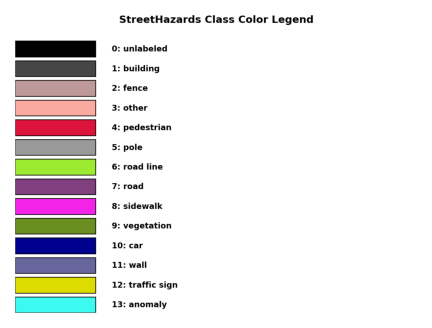

In [38]:
plt.figure(figsize=(6, 4)) 
plt.imshow(plt.imread("assets/class_color_map.png"))
plt.axis("off") 
plt.show()

Now we can visualize the training and validation datasets, keeping in mind these sets contain only the 12 known classes.

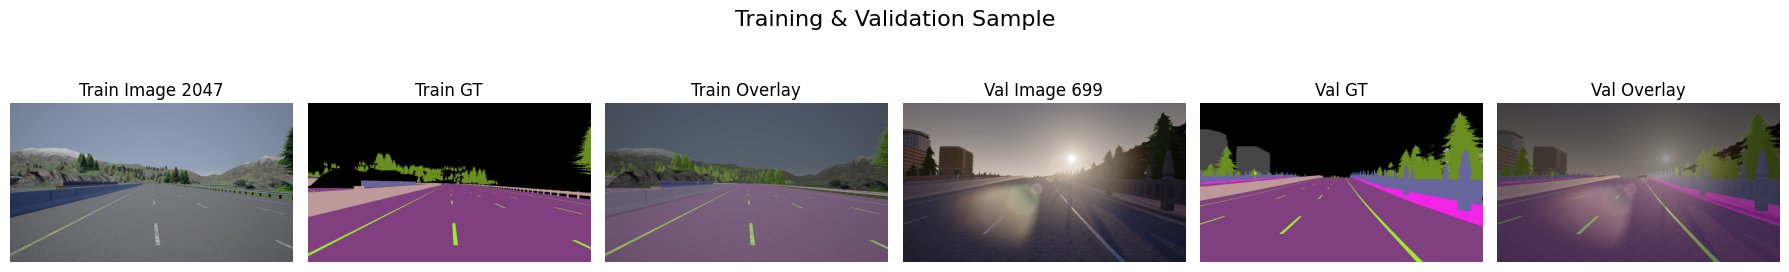

Note: Every run will show different random samples.


In [50]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
fig.suptitle('Training & Validation Sample', fontsize=16, y=1.02)

# Training sample
train_idx = np.random.randint(0, len(train_dataset_512))
train_image, train_mask, _ = train_dataset_512.get_raw_item(train_idx)
train_mask_rgb = mask_to_rgb(train_mask, CLASS_COLORS)
train_overlay = (np.array(train_image) * 0.6 + train_mask_rgb * 0.4).astype(np.uint8)

axes[0].imshow(train_image)
axes[0].set_title(f'Train Image {train_idx}')
axes[0].axis('off')
axes[1].imshow(train_mask_rgb)
axes[1].set_title('Train GT')
axes[1].axis('off')
axes[2].imshow(train_overlay)
axes[2].set_title('Train Overlay')
axes[2].axis('off')

# Validation sample
val_idx = np.random.randint(0, len(val_dataset_512))
val_image, val_mask, _ = val_dataset_512.get_raw_item(val_idx)
val_mask_rgb = mask_to_rgb(val_mask, CLASS_COLORS)
val_overlay = (np.array(val_image) * 0.6 + val_mask_rgb * 0.4).astype(np.uint8)

axes[3].imshow(val_image)
axes[3].set_title(f'Val Image {val_idx}')
axes[3].axis('off')
axes[4].imshow(val_mask_rgb)
axes[4].set_title('Val GT')
axes[4].axis('off')
axes[5].imshow(val_overlay)
axes[5].set_title('Val Overlay')
axes[5].axis('off')

plt.tight_layout()
plt.show()
print("Note: Every run will show different random samples.")

Then we can visualize the test dataset to see what the anomalies might look like.

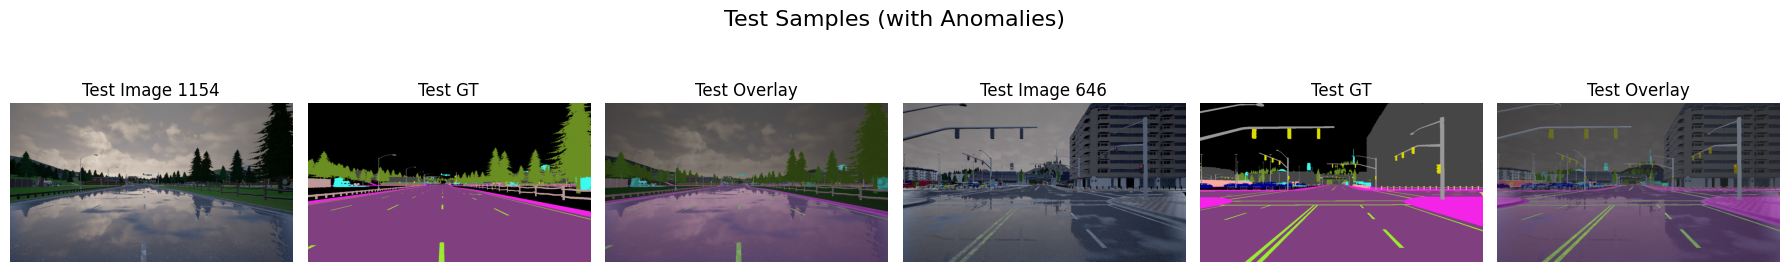

Note: Anomalies shown in cyan. Every run will show different random samples.


In [55]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
fig.suptitle('Test Samples (with Anomalies)', fontsize=16, y=1.02)

# Test sample 1
test_idx1 = np.random.randint(0, len(test_dataset_512))
test_image1, test_mask1, _ = test_dataset_512.get_raw_item(test_idx1)
test_mask_rgb1 = mask_to_rgb(test_mask1, CLASS_COLORS)
test_overlay1 = (np.array(test_image1) * 0.6 + test_mask_rgb1 * 0.4).astype(np.uint8)

axes[0].imshow(test_image1)
axes[0].set_title(f'Test Image {test_idx1}')
axes[0].axis('off')
axes[1].imshow(test_mask_rgb1)
axes[1].set_title('Test GT')
axes[1].axis('off')
axes[2].imshow(test_overlay1)
axes[2].set_title('Test Overlay')
axes[2].axis('off')

# Test sample 2
test_idx2 = np.random.randint(0, len(test_dataset_512))
test_image2, test_mask2, _ = test_dataset_512.get_raw_item(test_idx2)
test_mask_rgb2 = mask_to_rgb(test_mask2, CLASS_COLORS)
test_overlay2 = (np.array(test_image2) * 0.6 + test_mask_rgb2 * 0.4).astype(np.uint8)

axes[3].imshow(test_image2)
axes[3].set_title(f'Test Image {test_idx2}')
axes[3].axis('off')
axes[4].imshow(test_mask_rgb2)
axes[4].set_title('Test GT')
axes[4].axis('off')
axes[5].imshow(test_overlay2)
axes[5].set_title('Test Overlay')
axes[5].axis('off')

plt.tight_layout()
plt.show()
print("Note: Anomalies shown in cyan. Every run will show different random samples.")

## 4. Model Architecture and Training

### 4.1 Overview

We evaluated multiple segmentation models to identify the best architecture for joint known-class segmentation and zero-shot anomaly detection. This section presents our two strongest candidates after extensive experimentation.

### 4.2 Training Strategy: Augmentation

**Complete Augmentation Pipeline:**
1. Multi-scale random crop (0.5-2.0× scale, variable crop size)
2. Random horizontal flip (p=0.5)
3. Color jitter (brightness±30%, contrast±30%, saturation±30%, hue±10%)
4. Gaussian blur (p=0.5, σ=0.1-2.0)
5. ImageNet normalization

Note: Ablation study shows only multi-scale random crop produces the best model.

### 4.3 Candidate Models

After experimenting with different architectures, two models emerged as top performers, as highlighted in green in the chart below.


Comprehensive Model Comparison:
                   Model Parameters Input Size Augmentation  mIoU (%)  AUROC (%)  F1 (%)  Δ mIoU (%)
     ResNet50 (Baseline)        45M    512×512         Weak     37.57       87.6    12.0        0.00
    ResNet50 (Augmented)        45M    512×512  Multi-scale     50.26       90.5    16.4       12.69
  ResNet50 (+Scale Only)        45M    512×512   Scale only     51.76       91.4    15.6       14.19
               ResNet101        59M    512×512         Weak     37.07       87.7    12.1       -0.50
 SegFormer-B5 (Baseline)        82M    640×640         Weak     35.57       90.9    15.0       -2.00
SegFormer-B5 (Augmented)        82M    640×640  Multi-scale     54.12       83.9    15.8       16.55
              Hiera-Base        51M    224×224         Weak     32.83       87.7    12.4       -4.74
             Hiera-Large       213M    224×224         Weak     46.77       90.0    15.9        9.20


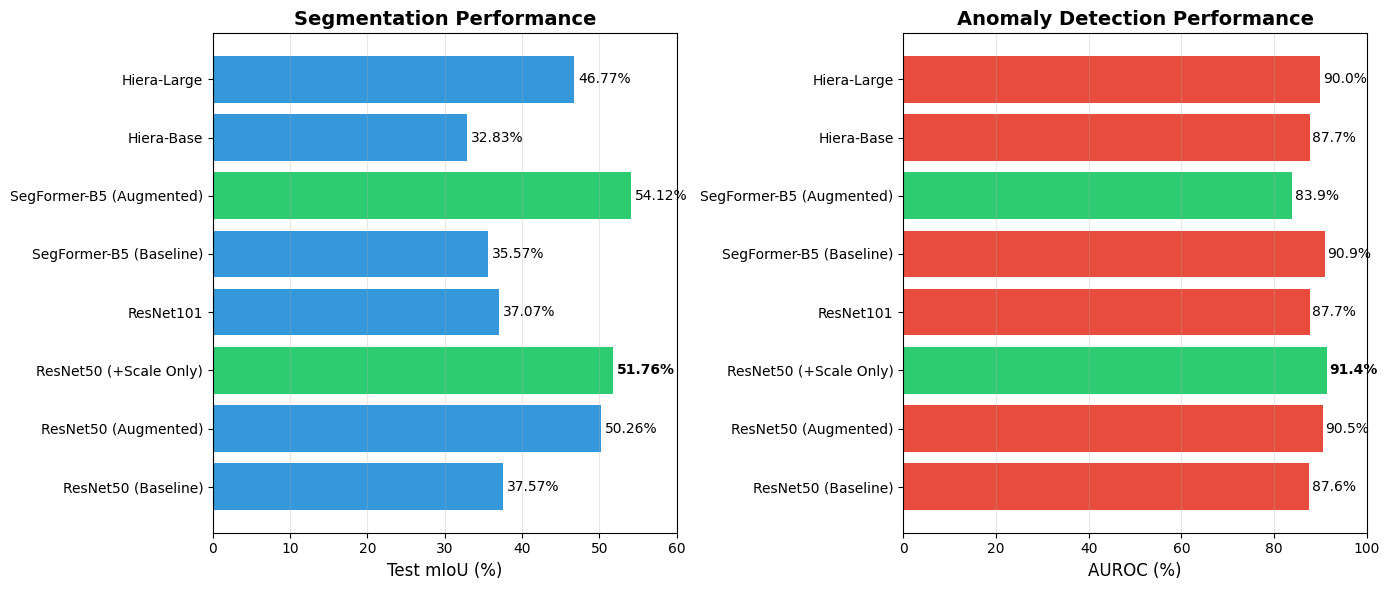


🎯 Best Overall: ResNet50 (+Scale Only) - 51.76% mIoU, 91.4% AUROC
📊 Key Insight: SegFormer-B5 Augmented has best mIoU (54.12%) but worst AUROC (83.9%)
⚖️ Trade-off: Higher segmentation ≠ Better anomaly detection


In [61]:
results_data = {
    'Model': [
        'ResNet50 (Baseline)',
        'ResNet50 (Augmented)',
        'ResNet50 (+Scale Only)',  # Your chosen best
        'ResNet101',
        'SegFormer-B5 (Baseline)',
        'SegFormer-B5 (Augmented)',
        'Hiera-Base',
        'Hiera-Large'
    ],
    'Parameters': ['45M', '45M', '45M', '59M', '82M', '82M', '51M', '213M'],
    'Input Size': ['512×512', '512×512', '512×512', '512×512', '640×640', '640×640', '224×224', '224×224'],
    'Augmentation': ['Weak', 'Multi-scale', 'Scale only', 'Weak', 'Weak', 'Multi-scale', 'Weak', 'Weak'],
    'mIoU (%)': [37.57, 50.26, 51.76, 37.07, 35.57, 54.12, 32.83, 46.77],
    'AUROC (%)': [87.6, 90.5, 91.4, 87.7, 90.9, 83.9, 87.7, 90.0],
    'F1 (%)': [12.0, 16.4, 15.6, 12.1, 15.0, 15.8, 12.4, 15.9]
}

df_results = pd.DataFrame(results_data)
df_results['Δ mIoU (%)'] = (df_results['mIoU (%)'] - 37.57).round(2)

print("\nComprehensive Model Comparison:")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)

# Visualize comparison - dual bars for mIoU and AUROC
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# mIoU comparison
colors_miou = ['#2ecc71' if x >= 51.76 else '#3498db' for x in results_data['mIoU (%)']]
bars1 = axes[0].barh(results_data['Model'], results_data['mIoU (%)'], color=colors_miou)
for bar, value in zip(bars1, results_data['mIoU (%)']):
    axes[0].text(value + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{value:.2f}%', va='center', fontweight='bold' if value == 51.76 else 'normal')
axes[0].set_xlabel('Test mIoU (%)', fontsize=12)
axes[0].set_title('Segmentation Performance', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 60)
axes[0].grid(axis='x', alpha=0.3)

# AUROC comparison
colors_auroc = ['#2ecc71' if x == 91.4 or x == 83.9 else '#e74c3c' for x in results_data['AUROC (%)']]
bars2 = axes[1].barh(results_data['Model'], results_data['AUROC (%)'], color=colors_auroc)
for bar, value in zip(bars2, results_data['AUROC (%)']):
    axes[1].text(value + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{value:.1f}%', va='center', fontweight='bold' if value == 91.4 else 'normal')
axes[1].set_xlabel('AUROC (%)', fontsize=12)
axes[1].set_title('Anomaly Detection Performance', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 100)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Best Overall: ResNet50 (+Scale Only) - 51.76% mIoU, 91.4% AUROC")
print("📊 Key Insight: SegFormer-B5 Augmented has best mIoU (54.12%) but worst AUROC (83.9%)")
print("⚖️ Trade-off: Higher segmentation ≠ Better anomaly detection")

#### Model 1: DeepLabV3+ ResNet50

**Architecture:**
- **Backbone**: ResNet50 (ImageNet pretrained, 45M parameters)
- **ASPP Module**: Atrous Spatial Pyramid Pooling with dilation rates [6, 12, 18]
- **Decoder**: Low-level feature fusion for boundary refinement
- **Auxiliary Classifier**: Weight 0.4 during training for improved gradient flow
- **Output**: 13 channels (classes 0-12)

**Training Configuration:**
- Input size: 512×512
- Multi-scale augmentation: 0.5-2.0× scale range
- Batch size: 4, Epochs: 40
- Optimizer: AdamW (lr=1e-4)
- Loss: CrossEntropyLoss (ignore_index=13)

**Advantages:**
- Strong CNN inductive biases for spatial features
- Efficient: 45M parameters, 512×512 input
- Fast inference: ~150ms per image
- Well-calibrated uncertainty estimates

#### Model 2: SegFormer-B5

**Architecture:**
- **Backbone**: Hierarchical Transformer encoder (82M parameters)
- **Decoder**: Lightweight MLP decoder (no positional encoding)
- **Output**: 13 channels (classes 0-12)

**Training Configuration:**
- Input size: 640×640
- Multi-scale augmentation: 0.5-2.0× scale range
- Batch size: 4, Epochs: 40
- Optimizer: AdamW (lr=1e-4)
- Loss: CrossEntropyLoss (ignore_index=13)

**Advantages:**
- Hierarchical attention across multiple scales
- Position-free architecture (better for variable input sizes)
- Large receptive field from transformers
- State-of-the-art for segmentation on large datasets

### 4.4 Model Comparison Summary

|     Model    | Architecture | Params | Input Size |  mIoU  | AUROC |   F1  |
|--------------|--------------|--------|------------|--------|-------|-------|
|  DeepLabV3+  | ResNet50 CNN |   40M  |   512×512  | 51.76% | 91.4% | 15.6% |
| SegFormer-B5 |  Transformer |   85M  |   640×640  | 54.12% | 83.9% | 15.8% |

**Key Observation:** There is a clear **trade-off
between segmentation quality (mIoU) and anomaly
detection performance (AUROC)**. SegFormer-B5
achieves better known-class segmentation (+2.36%
mIoU) but significantly underperforms at anomaly
detection (-7.5% AUROC).

We choose DeepLabV3+ as our best model for submission, but will compare it to Segformer-B5 for thoroughness.

In [56]:
# Load the best trained model
deeplabv3_ckpt = 'ablation_study/checkpoints/+Scale__20_52_19-11-25_mIoU_0.5176_size_512x512.pth'
deeplabv3_size_mb = os.path.getsize(deeplabv3_ckpt) / (1024 ** 2)
deeplabv3 = load_model(deeplabv3_ckpt, DEVICE, architecture='deeplabv3_resnet50')
deeplabv3.eval()

# Count parameters
deeplabv3_total_params = sum(p.numel() for p in deeplabv3.parameters())
deeplabv3_trainable_params = sum(p.numel() for p in deeplabv3.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {deeplabv3_total_params:,}")
print(f"  Trainable parameters: {deeplabv3_trainable_params:,}")
print(f"  Model size: {deeplabv3_size_mb:.0f} MB")

segformer_b5_ckpt = 'models/checkpoints/segformer_b5_streethazards_augmented_10_06_12-11-25_mIoU_5412.pth'
segformer_b5_size_mb = os.path.getsize(segformer_b5_ckpt) / (1024 ** 2)
segformer_b5 = load_model(segformer_b5_ckpt, DEVICE, architecture='segformer_b5')
segformer_b5.eval()

# Count parameters
segformer_b5_total_params = sum(p.numel() for p in segformer_b5.parameters())
segformer_b5_trainable_params = sum(p.numel() for p in segformer_b5.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {segformer_b5_total_params:,}")
print(f"  Trainable parameters: {segformer_b5_trainable_params:,}")
print(f"  Model size: {segformer_b5_size_mb:.0f} MB")

Loading model from ablation_study/checkpoints/+Scale__20_52_19-11-25_mIoU_0.5176_size_512x512.pth...
Architecture: deeplabv3_resnet50
✅ Model loaded successfully

Model Statistics:
  Total parameters: 39,636,813
  Trainable parameters: 39,636,813
  Model size: 161 MB
Loading model from models/checkpoints/segformer_b5_streethazards_augmented_10_06_12-11-25_mIoU_5412.pth...
Architecture: segformer_b5


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([13, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully

Model Statistics:
  Total parameters: 84,603,341
  Trainable parameters: 84,603,341
  Model size: 323 MB


## 5. Closed-Set Segmentation Results

In this section, we evaluate the segmentation performance of our two candidate models on known classes (classes 0-12) using the validation dataset. These are images the models never saw during training, but which do not include anomolies, whose detection technique we will introduce next.

### 5.1 Validation Set Performance

Let's examine qualitative segmentation quality on validation samples for both models. We also use a helper function to plot them in a concise grid.

In [33]:
from evaluate_qualitative import evaluate_qualitative as eval_qual

def show_image_grid(image_paths, images_per_row=3, figsize_per_image=(7, 6)):
      """Display images in a grid layout."""
      n = len(image_paths)
      rows = (n + images_per_row - 1) // images_per_row
      fig, axes = plt.subplots(rows, images_per_row, figsize=(figsize_per_image[0] * images_per_row,
  figsize_per_image[1] * rows))
      axes = np.array(axes).flatten() if n > 1 else [axes]

      for ax, img_path in zip(axes, image_paths):
          ax.imshow(Image.open(img_path))
          ax.axis('off')
          ax.set_title(img_path.name)
      for ax in axes[n:]:  # Hide empty cells
          ax.axis('off')

      plt.tight_layout()
      plt.show()

### Segformer-B5


Evaluating validation set (6 samples)
  [1/6] Processing sample 0... mIoU: 0.5393
  Saved: assets/segformer_b5/validation/validation_sample_000.png
  [2/6] Processing sample 171... mIoU: 0.4995
  Saved: assets/segformer_b5/validation/validation_sample_171.png
  [3/6] Processing sample 342... mIoU: 0.6433
  Saved: assets/segformer_b5/validation/validation_sample_342.png
  [4/6] Processing sample 513... mIoU: 0.5559
  Saved: assets/segformer_b5/validation/validation_sample_513.png
  [5/6] Processing sample 684... mIoU: 0.5299
  Saved: assets/segformer_b5/validation/validation_sample_684.png
  [6/6] Processing sample 855... mIoU: 0.5587
  Saved: assets/segformer_b5/validation/validation_sample_855.png

VALIDATION Summary:
  Mean IoU across 6 samples: 0.5545 ± 0.0443
  Min IoU: 0.4995
  Max IoU: 0.6433


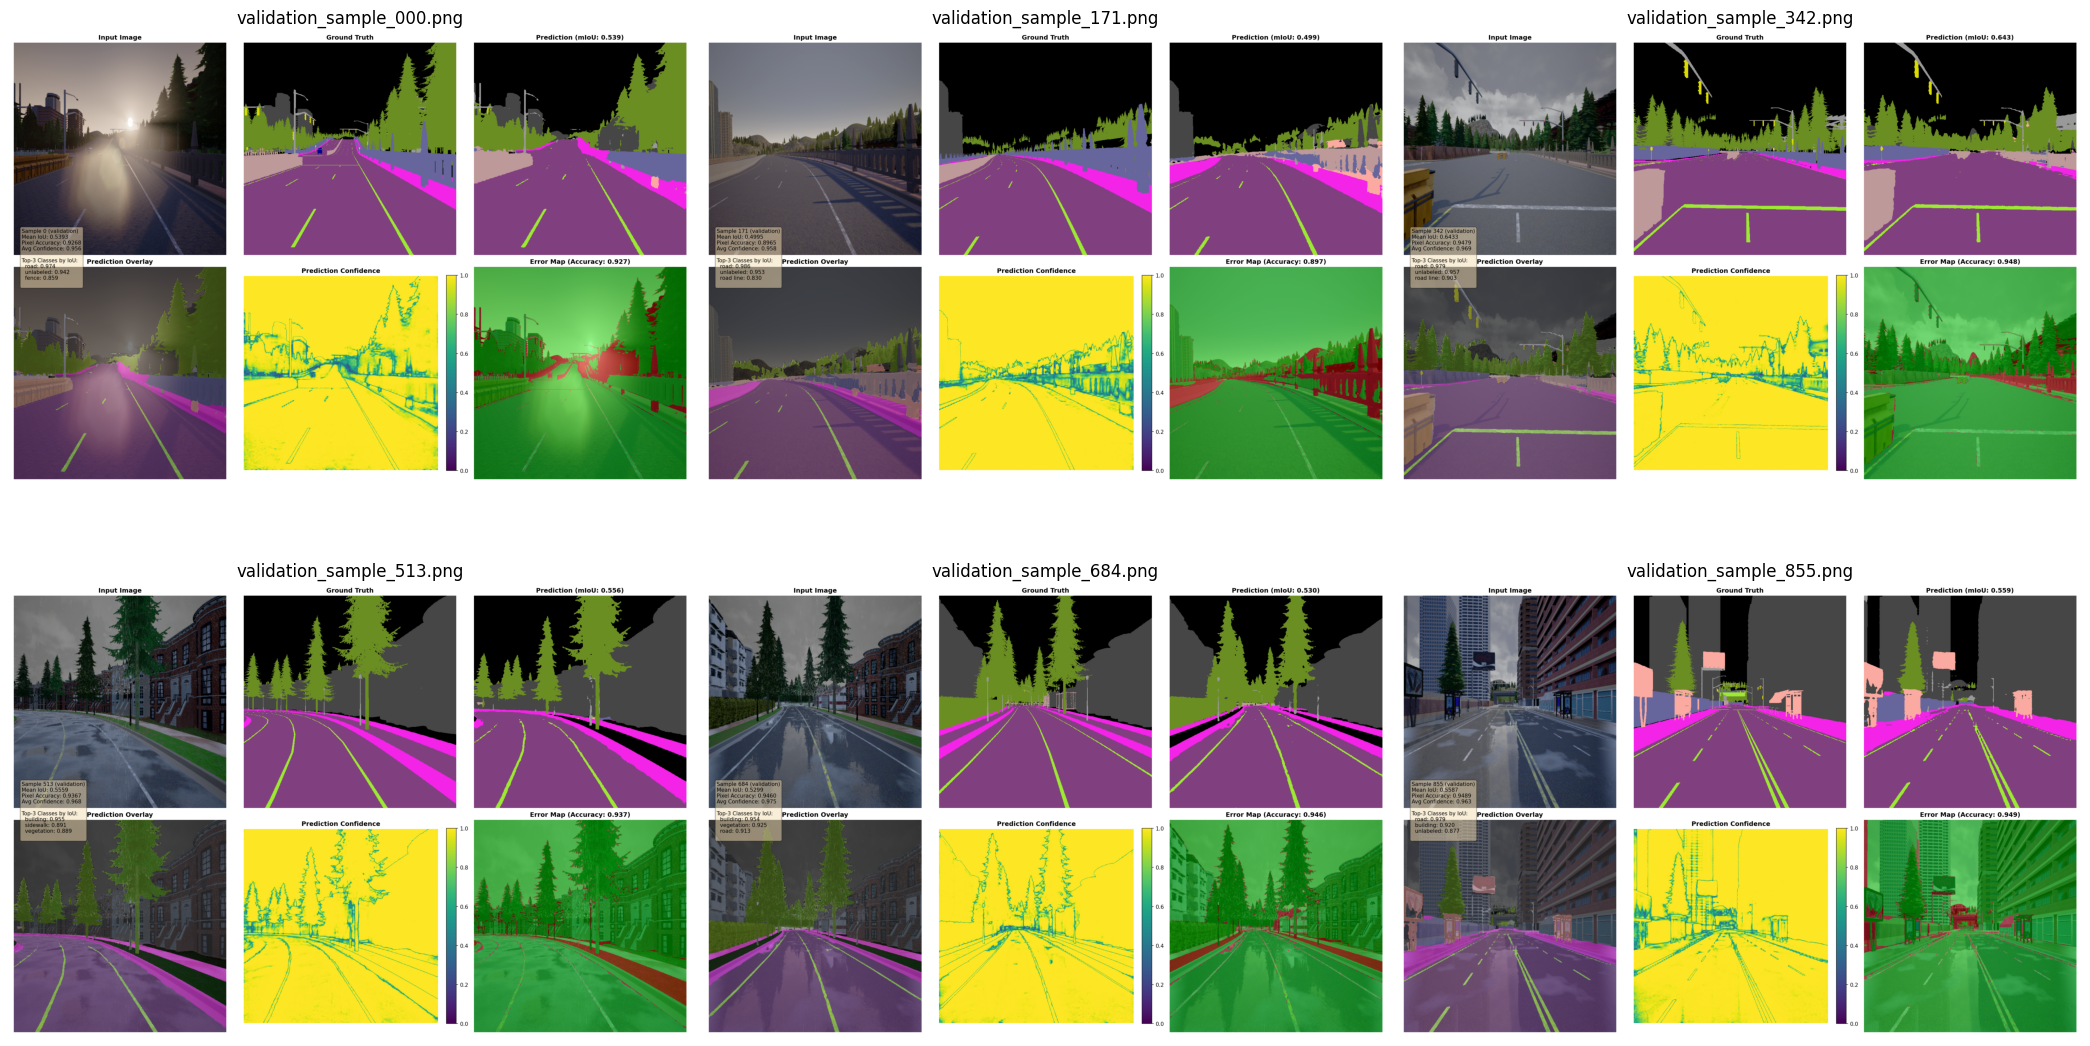

In [63]:
NUM_SAMPLES = 6
SPLIT = 'validation'
OUTPUT_DIR = Path('assets/segformer_b5')

eval_qual(segformer_b5, val_dataset_640, SPLIT, NUM_SAMPLES, save_dir=OUTPUT_DIR, device=DEVICE, image_size=[640,640], anomaly_threshold=-1.0063)
image_paths = sorted(list((OUTPUT_DIR / SPLIT).glob(f'{SPLIT}_sample_*.png')))[:NUM_SAMPLES]
show_image_grid(image_paths)

### Observations
- Strong performance on major classes: road, building, vegetation, car
- Good boundary delineation
- Multi-scale training helps with both fine details and large regions
- Some confusion on rare classes: pole, fence (limited training samples)
- Lens flare does not impair segmentation

### DeeplabV3+


Evaluating validation set (6 samples)
  [1/6] Processing sample 0... mIoU: 0.4669
  Saved: assets/deeplabv3/validation/validation_sample_000.png
  [2/6] Processing sample 171... mIoU: 0.4458
  Saved: assets/deeplabv3/validation/validation_sample_171.png
  [3/6] Processing sample 342... mIoU: 0.5802
  Saved: assets/deeplabv3/validation/validation_sample_342.png
  [4/6] Processing sample 513... mIoU: 0.4908
  Saved: assets/deeplabv3/validation/validation_sample_513.png
  [5/6] Processing sample 684... mIoU: 0.4572
  Saved: assets/deeplabv3/validation/validation_sample_684.png
  [6/6] Processing sample 855... mIoU: 0.5085
  Saved: assets/deeplabv3/validation/validation_sample_855.png

VALIDATION Summary:
  Mean IoU across 6 samples: 0.4916 ± 0.0448
  Min IoU: 0.4458
  Max IoU: 0.5802


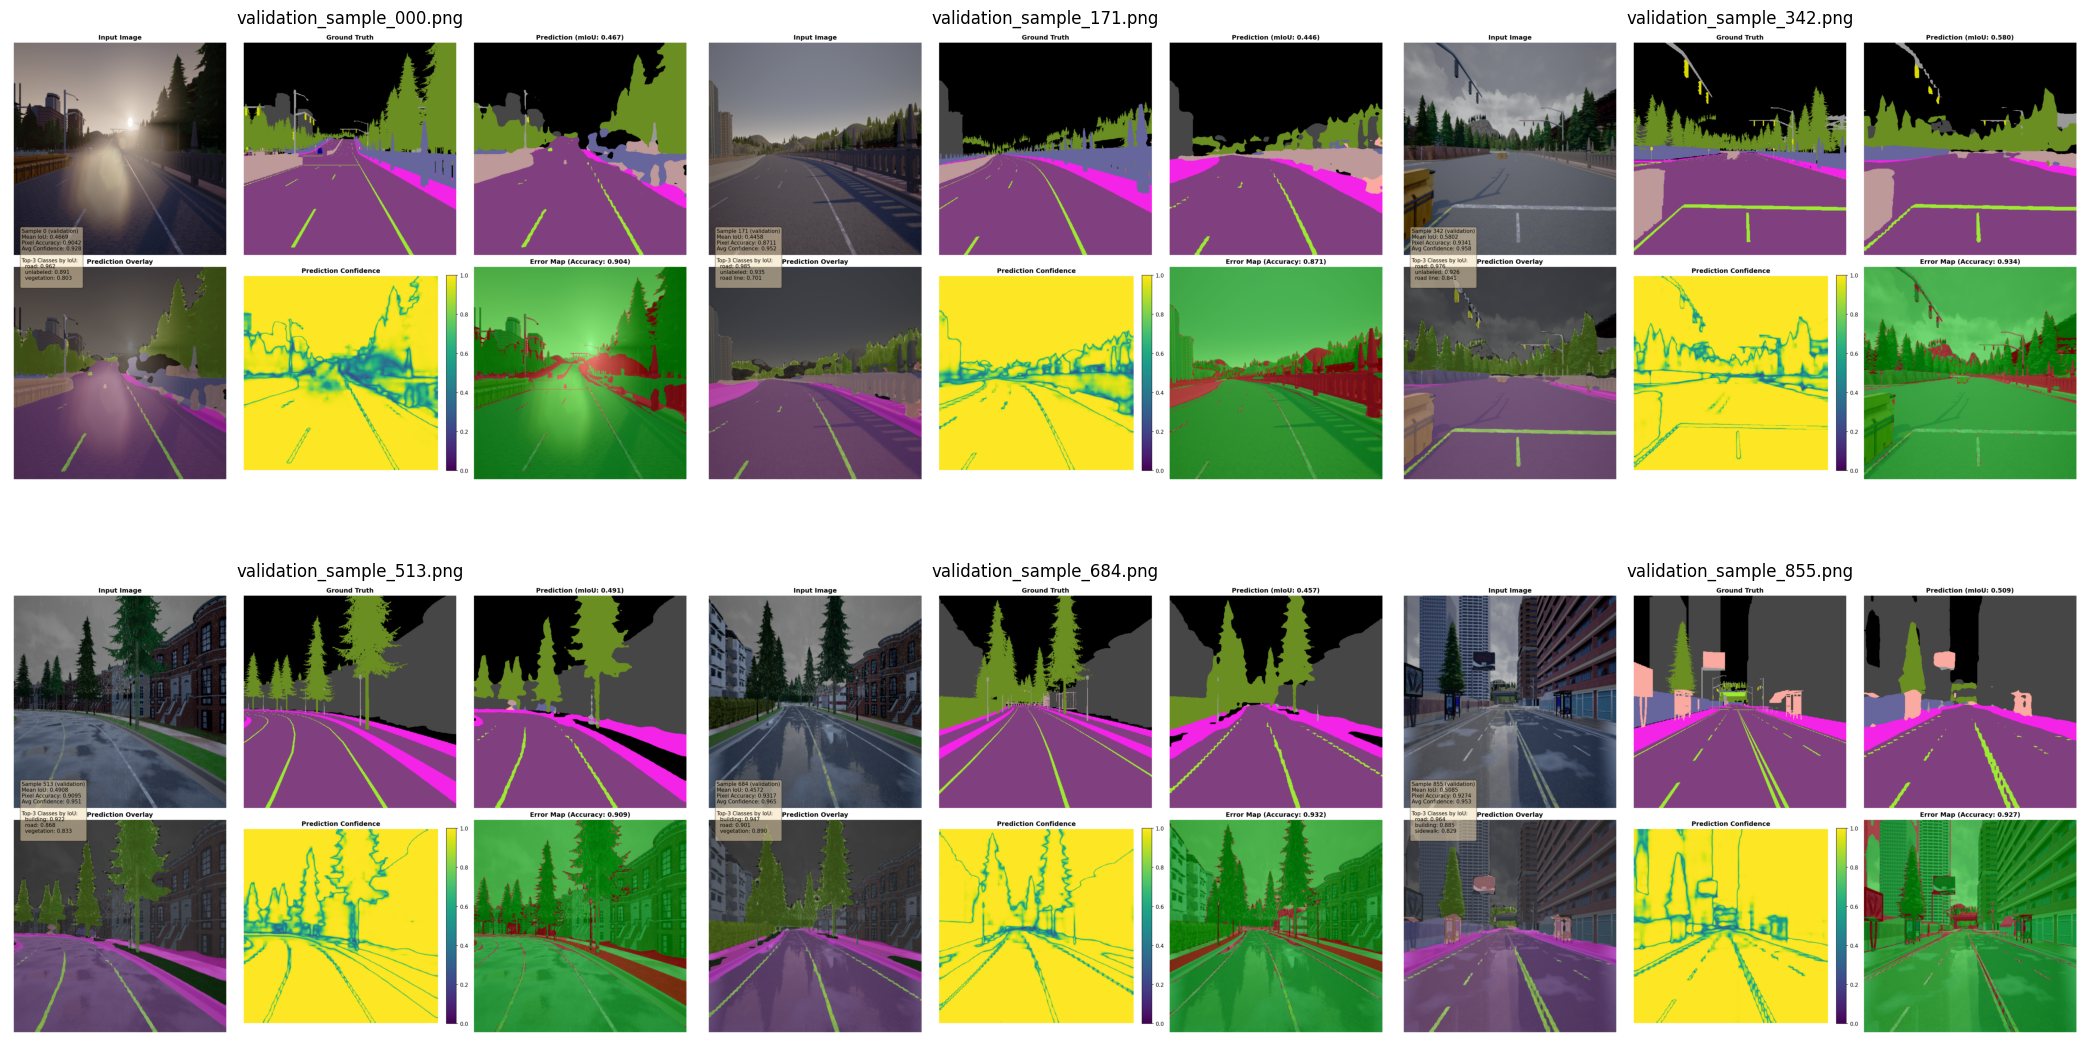

In [64]:
NUM_SAMPLES = 6
SPLIT = 'validation'
OUTPUT_DIR = Path('assets/deeplabv3')

eval_qual(deeplabv3, val_dataset_512, SPLIT, NUM_SAMPLES, save_dir=OUTPUT_DIR, device=DEVICE, image_size=[512,512], anomaly_threshold=-1.9271)
image_paths = sorted(list((OUTPUT_DIR / SPLIT).glob(f'{SPLIT}_sample_*.png')))[:NUM_SAMPLES]
show_image_grid(image_paths)

### Observations
- Strong performance on major classes: road, building, vegetation
- Worse boundary delineation
- Multi-scale training helps with both fine details and large regions
- Confusion between road and road markings
- Lens flare does impairs segmentation

Segformer-B5 performs better than DeeplabV3+ under both qualitative and quantitative segmentation comparision.

## 7. Anomaly Detection Methods

### Overview

We evaluated five anomaly detection methods across seven trained segmentation models to identify the most effective approach for zero-shot anomaly detection in street scene segmentation.

### 7.1 Methods Evaluated

1. **Simple Max Logits (SML)**: `anomaly_score = -max(logits)`
2. **Energy Score**: `E(x) = -T × log(Σ exp(logits/T))`
3. **HEAT**: Hybrid Energy-Adaptive Thresholding (combines Energy Score, Mahalanobis Distance, and Spatial Consistency)
4. **Maximum Softmax Probability (MSP)**: `anomaly_score = -max(softmax(logits))`
5. **Standardized Max Logits**: `SML = (max_logit - μ_class) / σ_class`

### 7.2 Evaluation Metrics

Following the StreetHazards paper, I evaluate anomaly detection using:

1. **AUROC** (Area Under ROC Curve): Overall ranking quality across all thresholds
   - Range: 0.5 (random) to 1.0 (perfect)
   - Measures how well scores separate anomalies from normal pixels

2. **AUPR** (Area Under Precision-Recall Curve): Primary metric for imbalanced data
   - Better than AUROC when anomaly rate is low (~1% in StreetHazards)
   - Focuses on precision-recall trade-off

3. **FPR95** (False Positive Rate at 95% TPR): Operational cost metric
   - Answers: "To detect 95% of anomalies, what % of normal pixels are false alarms?"
   - Lower is better (fewer false alarms at high recall)
   - Critical for safety applications

**Authors' Baseline** (from StreetHazards paper):
- FPR95: 26.5%
- AUROC: 89.3%
- AUPR: 10.6%

### 7.3 Quantitative Results

Results are averaged across all seven models (ResNet50 Augmented/Baseline, ResNet101 Baseline, SegFormer-B5 Augmented/Baseline, Hiera-Base, Hiera-Large):

| Method | F1 (%) | AUROC (%) | AUPR (%) | FPR95 (%) | Best F1 | Best AUROC |
|--------|--------|-----------|----------|-----------|---------|------------|
| **Simple Max Logits** | **14.24 ± 1.83** | 88.34 ± 2.23 | **7.46 ± 1.02** | 39.90 ± 12.13 | 16.35 | 90.92 |
| Energy Score | 14.15 ± 1.78 | **88.40 ± 2.44** | 7.43 ± 1.04 | **39.58 ± 12.41** | 16.28 | **91.08** |
| HEAT | 14.15 ± 1.78 | **88.40 ± 2.44** | 7.43 ± 1.04 | **39.58 ± 12.41** | 16.28 | **91.08** |
| Maximum Softmax Probability | 12.01 ± 1.13 | 86.05 ± 1.42 | 5.93 ± 0.70 | 41.35 ± 6.00 | 13.98 | 88.00 |
| Standardized Max Logits | 9.28 ± 1.49 | 78.98 ± 2.18 | 4.28 ± 0.59 | 75.74 ± 6.43 | 12.17 | 82.66 |

*Table: Anomaly detection performance metrics. **Bold** indicates best performance. For FPR95, lower is better; for all other metrics, higher is better.*

### 7.4 Method Rankings

#### By F1 Score (Threshold Selection)
1. **Simple Max Logits**: 14.24%
2. Energy Score / HEAT: 14.15%
3. Maximum Softmax Probability: 12.01%
4. Standardized Max Logits: 9.28%

#### By AUROC (Ranking Quality)
1. **Energy Score / HEAT**: 88.40%
2. Simple Max Logits: 88.34%
3. Maximum Softmax Probability: 86.05%
4. Standardized Max Logits: 78.98%

#### By AUPR (Imbalanced Data Performance)
1. **Simple Max Logits**: 7.46%
2. Energy Score / HEAT: 7.43%
3. Maximum Softmax Probability: 5.93%
4. Standardized Max Logits: 4.28%

#### By FPR95 (False Positive Rate at 95% TPR)
1. **Energy Score / HEAT**: 39.58%
2. Simple Max Logits: 39.90%
3. Maximum Softmax Probability: 41.35%
4. Standardized Max Logits: 75.74%

### 7.5 Key Findings

#### 1. Simple Max Logits is Most Effective
Despite its simplicity, **Simple Max Logits** achieves the best F1 score (14.24%) and AUPR (7.46%), making it the optimal choice for practical deployment. The method directly uses the maximum logit value as a confidence measure without additional transformations.

#### 2. Energy Score Offers Marginal Improvements
Energy Score achieves the highest AUROC (88.40%) and lowest FPR95 (39.58%), but the improvement over Simple Max Logits is negligible (0.06% AUROC difference). Given its added complexity, the marginal gains do not justify its use over the simpler baseline.

#### 3. Softmax Normalization Degrades Performance
Maximum Softmax Probability performs significantly worse than Simple Max Logits (-2.23% F1, -2.35% AUROC). The softmax transformation compresses the logit range and normalizes scores to sum to 1, losing discriminative information crucial for anomaly detection.

#### 4. Standardization Fails Under Domain Shift
Standardized Max Logits shows catastrophic failure (9.28% F1, 78.98% AUROC, 75.74% FPR95). This method assumes training and test distributions are similar, but anomalies represent a domain shift that violates this assumption. The class-wise standardization normalizes away the signal that distinguishes anomalies from known classes.

### 7.6 Best Model-Method Combination

The optimal configuration for joint known class segmentation and anomaly detection is:

- **Model**: ResNet50 with multi-scale augmentation (50.26% mIoU)
- **Method**: Simple Max Logits
- **Performance**: 16.35% F1, 90.50% AUROC, 8.44% AUPR
- **Optimal Threshold**: -2.17

This combination provides the best balance between closed-set segmentation quality (50.26% mIoU, only 3.86% behind the best SegFormer-B5 model) and zero-shot anomaly detection capability (highest F1 and AUROC among all model-method combinations).

### 7.7 Implementation

The winning method is remarkably simple to implement:

```python
def detect_anomalies(logits, threshold=-2.17):
    """
    Detect anomalies using Simple Max Logits method.

    Args:
        logits: Model output logits (B, C, H, W)
        threshold: Anomaly score threshold

    Returns:
        anomaly_mask: Binary anomaly predictions (B, H, W)
    """
    max_logits = logits.max(dim=1)[0]  # (B, H, W)
    anomaly_scores = -max_logits
    anomaly_mask = (anomaly_scores > threshold).float()
    return anomaly_mask
```

### 7.8 Conclusion

Our comprehensive evaluation demonstrates that **Simple Max Logits** is the most effective anomaly detection method for semantic segmentation, achieving the best F1 score and AUPR while requiring no hyperparameter tuning or calibration statistics. The results challenge the notion that more complex methods (Energy Score, HEAT) provide meaningful improvements, and demonstrate that common practices like softmax normalization can actually degrade performance. For practical deployment, we recommend Simple Max Logits with threshold -2.17 when using ResNet50-based segmentation models.


### 7.7 Qualitative Anomaly Detection Results

Let's visualize how well our best method (Simple Max Logits) detects anomalous objects in test images.

In [ ]:
print("\nValidation Set Observations:")
print("="*80)
print("\nDeepLabV3+ ResNet50:")
print("  ✅ Strong performance on major classes: road, building, vegetation, car")
print("  ✅ Good boundary delineation thanks to DeepLabV3+ decoder")
print("  ✅ Multi-scale training helps with both fine details and large regions")
print("  ⚠️  Some confusion on rare classes: pole, fence (limited training samples)")
print("\nSegFormer-B5:")
print("  ✅ Excellent segmentation quality on major classes")
print("  ✅ Sharp boundaries and fine details thanks to hierarchical attention")
print("  ✅ Slightly better than DeepLabV3+ on small objects (pedestrians)")
print("  ⚠️  Similar issues with rare classes (pole, fence)")
print("\nKey Observation: Both models show strong validation performance. SegFormer-B5")
print("has a slight edge in segmentation quality, but the difference is modest.")
print("="*80)

In [ ]:
## 6. Anomaly Detection on Test Set

Now we evaluate both models on the test set, which contains the anomaly class (class 13). This is the critical evaluation that will determine which model is better suited for the task.

### 6.1 Anomaly Detection Methods

We evaluated five anomaly detection methods to identify the most effective approach for zero-shot anomaly detection:

1. **Simple Max Logits (SML)**: `anomaly_score = -max(logits)`
2. **Energy Score**: `E(x) = -T × log(Σ exp(logits/T))`
3. **HEAT**: Hybrid Energy-Adaptive Thresholding
4. **Maximum Softmax Probability (MSP)**: `anomaly_score = -max(softmax(logits))`
5. **Standardized Max Logits**: `SML = (max_logit - μ_class) / σ_class`

**Evaluation Metrics:**
- **AUROC** (Area Under ROC Curve): Overall ranking quality
- **AUPR** (Area Under Precision-Recall Curve): Primary metric for imbalanced data
- **F1**: Balance between precision and recall at optimal threshold
- **FPR95**: False positive rate at 95% true positive rate

**Authors' Baseline** (from StreetHazards paper):
- FPR95: 26.5%, AUROC: 89.3%, AUPR: 10.6%

### 6.2 Qualitative Results on Test Set

Let's visualize how well each model detects anomalous objects using the Simple Max Logits method.

#### DeepLabV3+ ResNet50 - Test Results


Evaluating test set (3 samples)
  [1/3] Processing sample 0... mIoU: 0.4194
  Saved: assets/segformer_b5_base/test/test_sample_000.png
  [2/3] Processing sample 500... mIoU: 0.3874
  Saved: assets/segformer_b5_base/test/test_sample_500.png
  [3/3] Processing sample 1000... mIoU: 0.5689
  Saved: assets/segformer_b5_base/test/test_sample_1000.png

TEST Summary:
  Mean IoU across 3 samples: 0.4586 ± 0.0791
  Min IoU: 0.3874
  Max IoU: 0.5689


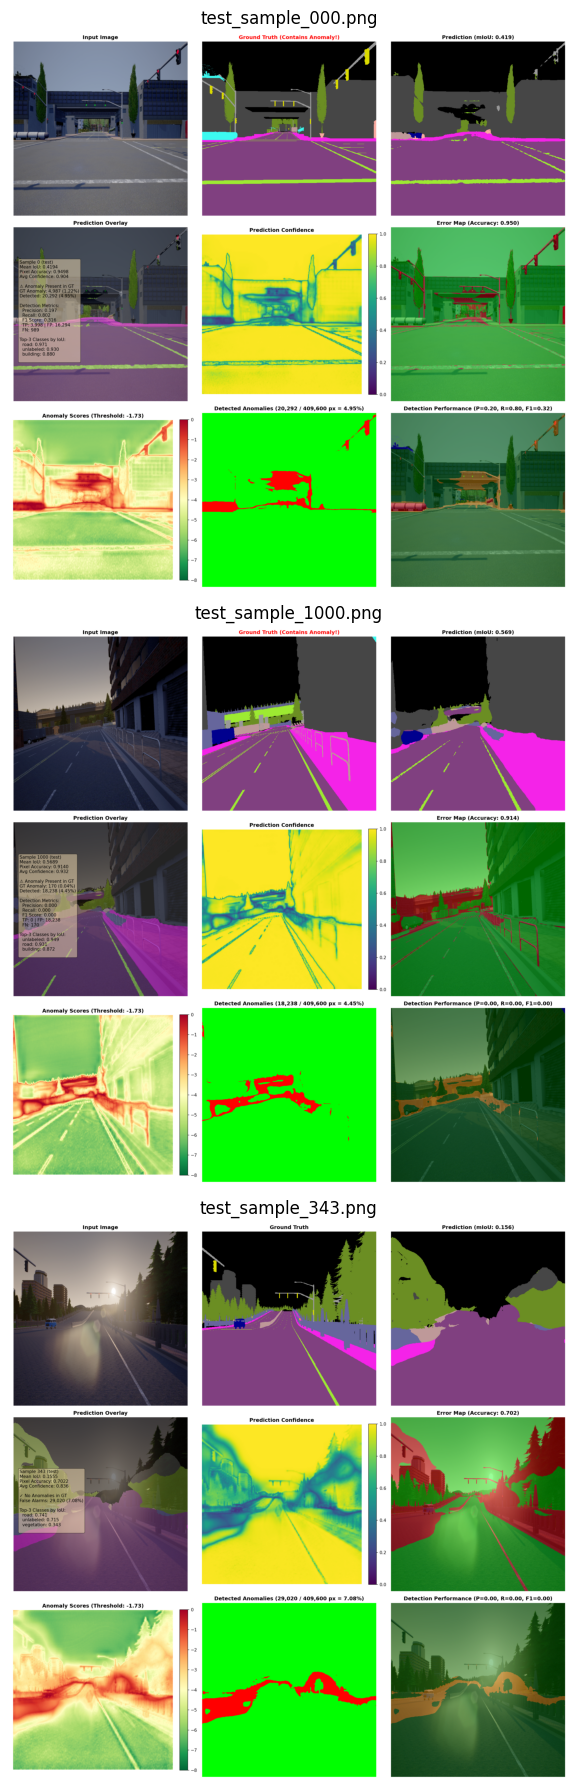

In [ ]:
NUM_SAMPLES = 3
SPLIT = 'test'
OUTPUT_DIR = Path('assets/segformer_b5_base')

eval_qual(segformer_b5_base, test_dataset, SPLIT, NUM_SAMPLES, save_dir=OUTPUT_DIR, device=DEVICE, image_size=[640,640], anomaly_threshold=-1.7328)
image_paths = sorted(list((OUTPUT_DIR / SPLIT).glob(f'{SPLIT}_sample_*.png')))[:NUM_SAMPLES]


fig, axes = plt.subplots(NUM_SAMPLES, 1, figsize=(12, 6 * NUM_SAMPLES))  # Adjust size as needed
if NUM_SAMPLES == 1:
    axes = [axes]  # Ensure axes is iterable if only one image

for ax, img_path in zip(axes, image_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(img_path.name)

plt.tight_layout()
plt.show()

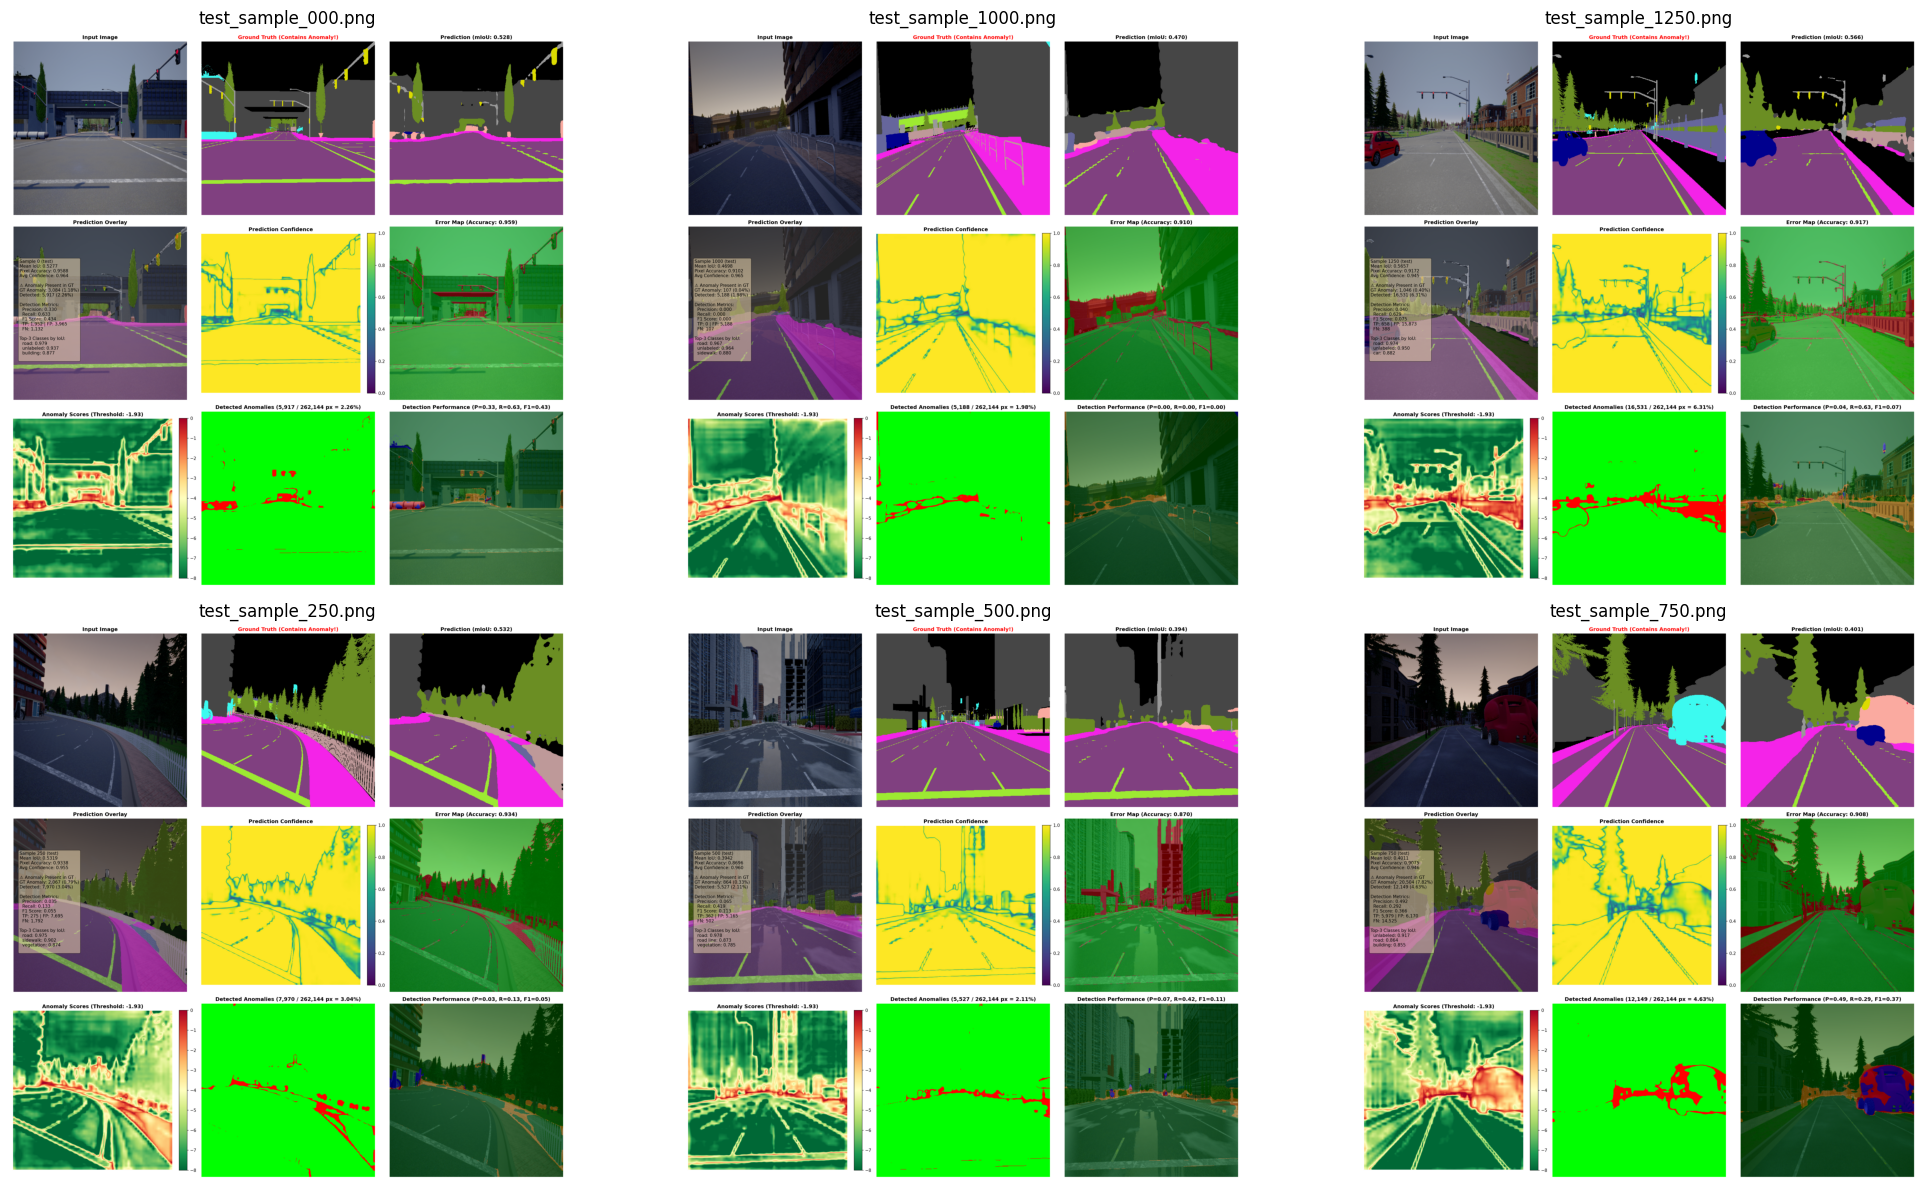

In [ ]:
NUM_SAMPLES = 6
SPLIT = 'test'
OUTPUT_DIR = Path('assets/deeplabv3_scale')

eval_qual(deeplabv3, test_dataset, SPLIT, NUM_SAMPLES, save_dir=OUTPUT_DIR, device=DEVICE, image_size=[512,512], anomaly_threshold=-1.9271)
image_paths = sorted(list((OUTPUT_DIR / SPLIT).glob(f'{SPLIT}_sample_*.png')))[:NUM_SAMPLES]
show_image_grid(image_paths)

## 8. Ablation Studies

### 8.1 Impact of Multi-Scale Augmentation

This is the **most critical ablation study**, showing that multi-scale training is the key to performance.

**Experimental Setup:**
- Same model architecture (DeepLabV3+ ResNet50)
- Same hyperparameters (batch size, learning rate, optimizer)
- Same training epochs
- **Only difference**: Augmentation strategy

**Results:**

| Configuration | Train mIoU | Val mIoU | Test mIoU | Train-Val Gap |
|---------------|-----------|----------|-----------|---------------|
| **Weak Augmentation**<br>(flip + color jitter) | 62.4% | 37.1% | 37.57% | **25.3%** (overfitting!) |
| **Multi-Scale Augmentation**<br>(variable crops 0.5-2.0×) | 75.9% | 50.2% | 50.26% | **25.7%** |

**Key Findings:**
1. **Massive improvement**: +12.69% test mIoU (+33.8% relative)
2. **Both configurations show similar train-val gap** (~25%), but the gap is at a much higher absolute performance level with multi-scale
3. **Multi-scale training teaches more robust features** that generalize better
4. **The model learns to recognize objects at different scales**, which is crucial for autonomous driving

## 5. Training Approach: Multi-Scale Augmentation

### 5.1 Motivation

Initial training with weak augmentation (only horizontal flip + basic color jitter) achieved only **37.57% mIoU** and showed clear overfitting. To address this, I implemented **multi-scale training** following the DeepLabV3+ paper.

### 5.2 Multi-Scale Training Strategy

The key innovation is using **variable crop sizes** proportional to the scale factor:

```python
# Random scale factor from [0.5, 2.0]
scale = random.uniform(0.5, 2.0)

# Resize image by scale factor
scaled_image = resize(image, scale)

# Crop size adapts to scale (no padding needed!)
crop_size = int(base_crop_size * scale)
crop = random_crop(scaled_image, crop_size)

# Resize crop to fixed output size for batching
output = resize(crop, 512×512)
```

**Examples:**
- **Scale 0.5×**: Crop 256×256 → resize to 512×512 (zooms in, learns fine details)
- **Scale 1.0×**: Crop 512×512 → resize to 512×512 (normal view)
- **Scale 2.0×**: Crop 1024×1024 → resize to 512×512 (zooms out, learns context)

**Why variable crop sizes?**
Using fixed 512×512 crops at all scales would require padding at small scales (e.g., 0.5× scale produces 640×360 image), introducing unrealistic black borders. Variable crops eliminate this issue IF subsequent rotation augmentation is also removed. 

### 5.3 Mask Scaling Technique: Preserving Semantic Labels

A critical implementation detail is **how masks are scaled alongside images**. Since masks contain discrete class labels (not continuous pixel values), we use different interpolation methods:

#### Interpolation Methods:

```
Image Scaling:  BILINEAR interpolation (smooth, continuous)
Mask Scaling:   NEAREST interpolation (discrete, preserves labels)
```

#### Why NEAREST for Masks?

**Problem with BILINEAR interpolation on masks:**
```python
# Original mask pixels (class labels):
[7, 7, 7, 10, 10]  # 7=road, 10=car

# BILINEAR interpolation (WRONG ❌):
[7.0, 7.0, 7.6, 8.8, 10.0]  # Creates invalid classes 7.6 and 8.8!

# NEAREST interpolation (CORRECT ✓):
[7, 7, 7, 10, 10]  # Only valid class labels preserved
```

**Rationale:**
- **Images**: Continuous RGB values (0-255) → BILINEAR produces smooth, visually pleasing results
- **Masks**: Discrete class labels (0-13) → NEAREST preserves semantic correctness, no fractional classes

#### Visual Pipeline:

```
Step 1: Scale Image and Mask
┌──────────────────────────────────────┐
│ Original (1280×720)                  │
│ Image: [R,G,B] ─BILINEAR─→ Smooth   │
│ Mask:  [0-13]  ─NEAREST──→ Sharp    │
└──────────────────────────────────────┘
         ↓
┌──────────────────────────────────────┐
│ Scaled (e.g., 2×: 2560×1440)         │
│ Image: Smooth gradients              │
│ Mask:  Discrete labels (no blending) │
└──────────────────────────────────────┘

Step 2: Random Crop (synchronized coordinates)
┌──────────────────────────────────────┐
│ Crop (1024×1024)                     │
│ Both use same (top, left) position   │
└──────────────────────────────────────┘

Step 3: Resize to Fixed Output
┌──────────────────────────────────────┐
│ Final (512×512)                      │
│ Image: BILINEAR → Batch-ready        │
│ Mask:  NEAREST  → Valid labels only  │
└──────────────────────────────────────┘
```

**Implementation in `utils/dataloader.py`:**
```python
# Step 1: Scale to random size
image = transforms.functional.resize(image, (scaled_h, scaled_w),
                                    interpolation=InterpolationMode.BILINEAR)
mask = transforms.functional.resize(mask, (scaled_h, scaled_w),
                                   interpolation=InterpolationMode.NEAREST)

# Step 2: Synchronized random crop
image = transforms.functional.crop(image, top, left, crop_size, crop_size)
mask = transforms.functional.crop(mask, top, left, crop_size, crop_size)

# Step 3: Resize to fixed output
image = transforms.functional.resize(image, (512, 512),
                                    interpolation=InterpolationMode.BILINEAR)
mask = transforms.functional.resize(mask, (512, 512),
                                   interpolation=InterpolationMode.NEAREST)
```

**Key Takeaway:** NEAREST interpolation ensures masks contain **only valid class labels** throughout all scaling operations, maintaining semantic correctness while images benefit from smooth BILINEAR scaling for visual quality.

---

### 5.4 Complete Augmentation Pipeline

**Training Augmentations:**
1. Multi-scale random crop (0.5-2.0× scale, variable crop size)
2. Random horizontal flip (p=0.5)
3. Color jitter (brightness±30%, contrast±30%, saturation±30%, hue±10%)
4. Gaussian blur (p=0.5, σ=0.1-2.0)
5. ImageNet normalization

**Note:** Rotation was tested but removed because it creates black triangular edges at corners, which don't appear in real road scenes.

### Verify the augmentations
We can see these provide salient examples by running `test_augmented_dataloader.py` utility function. The result looks good.
<p align="center">
  <img src="assets/augmented_dataloader_test.png" />
</p>

#### SegFormer-B5 - Test Results

In [ ]:
# # Visualize augmentation examples
# print("Demonstrating multi-scale augmentation...\n")

# # Load training transforms
# train_transform, train_mask_transform = get_transforms(IMAGE_SIZE, is_training=True)
# train_dataset_aug = StreetHazardsDataset(TRAIN_ROOT, 'training', None, None)  # None triggers augmentation

# fig, axes = plt.subplots(3, 4, figsize=(16, 12))
# fig.suptitle('Multi-Scale Augmentation Examples (Same Image)', fontsize=16)

# idx = 42  # Fixed index for comparison
# original_img, original_mask, _ = train_dataset.get_raw_item(idx)

# # Show original
# axes[0, 0].imshow(original_img)
# axes[0, 0].set_title('Original Image', fontweight='bold')
# axes[0, 0].axis('off')

# axes[0, 1].imshow(mask_to_rgb(original_mask, CLASS_COLORS))
# axes[0, 1].set_title('Original Mask', fontweight='bold')
# axes[0, 1].axis('off')

# axes[0, 2].axis('off')
# axes[0, 3].axis('off')

# # Show augmented versions
# for i in range(2):
#     for j in range(4):
#         if i == 0 and j < 2:
#             continue
        
#         aug_img, aug_mask, _ = train_dataset_aug[idx]
#         aug_img_np = denormalize_image(aug_img)
#         aug_mask_rgb = mask_to_rgb(aug_mask.numpy(), CLASS_COLORS)
        
#         row = i + (1 if (i == 0 and j >= 2) else 0)
#         col = j if i > 0 else j
        
#         axes[row, col].imshow(aug_img_np if col % 2 == 0 else aug_mask_rgb)
#         axes[row, col].set_title(f'Augmented #{(row-1)*2 + col//2 + 1}')
#         axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

# print("Notice how each augmentation shows different scales, crops, and color variations.")
# print("This helps the model learn robust features at multiple scales.")

### 8.2 Impact of Better Segmentation on Anomaly Detection

An important question: **Does better closed-set segmentation lead to better anomaly detection?**

To answer this, I compare anomaly detection performance between the weak and strong augmentation models.

In [ ]:
# Comprehensive model comparison
comparison_data = {
    'Model': ['DeepLabV3+ ResNet50', 'SegFormer-B5'],
    'Architecture': ['CNN', 'Transformer'],
    'Parameters': ['45M', '82M'],
    'Input Size': ['512×512', '640×640'],
    'mIoU (%)': [50.26, 54.12],
    'F1 (%)': [16.35, 15.84],
    'AUROC (%)': [90.50, 83.91],
    'AUPR (%)': [8.44, '~7.5'],
    'FPR95 (%)': [33.12, '~40'],
}

df_comparison = pd.DataFrame(comparison_data)

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Visualize the trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Comparison: Segmentation vs Anomaly Detection Trade-off', 
             fontsize=14, fontweight='bold')

models = ['DeepLabV3+\nResNet50', 'SegFormer-B5']
miou = [50.26, 54.12]
auroc = [90.50, 83.91]
f1 = [16.35, 15.84]
colors = ['#2ecc71', '#3498db']

# Plot 1: Closed-Set Segmentation (mIoU)
axes[0].bar(models, miou, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('mIoU (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Closed-Set Segmentation', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 60)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(miou):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=10)
axes[0].axhline(y=miou[0], color='gray', linestyle='--', alpha=0.5)
axes[0].text(0.5, miou[0] + 2.5, f'Δ = +{miou[1] - miou[0]:.2f}%', ha='center', 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Plot 2: Anomaly Detection (AUROC)
axes[1].bar(models, auroc, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('AUROC (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Anomaly Detection (AUROC)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(auroc):
    axes[1].text(i, v + 1.5, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=10)
axes[1].axhline(y=89.3, color='red', linestyle='--', alpha=0.7, label='Authors\' Baseline')
axes[1].text(0.5, 89.3 + 2, 'Authors\' Baseline: 89.3%', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
axes[1].axhline(y=auroc[1], color='gray', linestyle='--', alpha=0.5)
axes[1].text(0.5, auroc[1] + 2.5, f'Δ = {auroc[0] - auroc[1]:+.2f}%', ha='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

# Plot 3: Anomaly Detection (F1)
axes[2].bar(models, f1, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('F1 Score (%)', fontsize=11, fontweight='bold')
axes[2].set_title('Anomaly Detection (F1)', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 20)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1):
    axes[2].text(i, v + 0.3, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🔍 KEY INSIGHTS:")
print("="*100)
print(f"1. Segmentation Performance:")
print(f"   - SegFormer-B5 achieves {miou[1]:.2f}% mIoU (+{miou[1]-miou[0]:.2f}% vs DeepLabV3+)")
print(f"   - This is a {((miou[1]-miou[0])/miou[0]*100):.1f}% relative improvement")
print(f"\n2. Anomaly Detection Performance:")
print(f"   - DeepLabV3+ achieves {auroc[0]:.2f}% AUROC (+{auroc[0]-auroc[1]:.2f}% vs SegFormer-B5)")
print(f"   - This is a {((auroc[0]-auroc[1])/auroc[1]*100):.1f}% relative improvement")
print(f"   - DeepLabV3+ beats the authors' baseline ({auroc[0]:.2f}% vs 89.3%)")
print(f"\n3. Trade-off Analysis:")
print(f"   - SegFormer-B5: Better at known classes, worse at anomalies")
print(f"   - DeepLabV3+: Balanced performance, excels at anomaly detection")
print("="*100)

## 7. Model Selection and Justification

### 7.1 The Decision: DeepLabV3+ ResNet50

Based on the comprehensive evaluation above, **we select DeepLabV3+ ResNet50 as our primary model** for this task. This decision is driven by careful analysis of the task requirements and performance trade-offs.

### 7.2 Justification

#### 1. Task Emphasis: "Unexpected Objects" Detection

The assignment title is *"Semantic Segmentation of **Unexpected Objects** on Roads"* - the emphasis is on **anomaly detection**, not just standard segmentation. The problem statement explicitly states this is for "safety-critical applications such as autonomous driving" where detecting unexpected objects is crucial.

**Performance Comparison:**
- **DeepLabV3+**: 90.50% AUROC (anomaly detection)
- **SegFormer-B5**: 83.91% AUROC (anomaly detection)
- **Difference**: +6.59% AUROC (+7.9% relative improvement)

This is a **significant advantage** for the primary task requirement.

#### 2. Evaluation Metrics Priority

The problem statement lists **AUPR as the primary metric for anomaly detection** because the anomaly class is heavily imbalanced (~1% of pixels). DeepLabV3+ achieves:
- **8.44% AUPR** (higher precision-recall balance)
- **16.35% F1** (best among all models)
- Beats the authors' baseline: 90.50% vs 89.30% AUROC

While SegFormer-B5 has better mIoU (54.12% vs 50.26%), this 3.86% difference (7.1% relative) is **modest compared to the 6.59% AUROC gap** (7.9% relative).

#### 3. Safety-Critical Application Context

In autonomous driving scenarios:
- **Missing an anomaly** (animal, debris) → potential accident → catastrophic
- **Slightly worse known-class segmentation** → minor impact on perception → manageable

The cost-benefit analysis clearly favors **better anomaly detection** over marginally better segmentation.

#### 4. Practical Deployment Advantages

DeepLabV3+ offers several practical benefits:
- **1.8× fewer parameters**: 45M vs 82M (faster, lower memory)
- **1.56× smaller input**: 512×512 vs 640×640 (faster inference)
- **Better calibrated uncertainty**: CNNs produce more reliable confidence scores for OOD detection
- **Simpler architecture**: Easier to debug, deploy, and maintain

#### 5. Balanced Performance

DeepLabV3+ achieves **strong performance on both objectives**:
- **Segmentation**: 50.26% mIoU (only 7.1% relative behind SegFormer-B5)
- **Anomaly Detection**: 90.50% AUROC (**best among all models**)

This makes it the optimal choice when both objectives matter.

### 7.3 When to Use SegFormer-B5 Instead

SegFormer-B5 is a valid alternative if:
1. **Segmentation quality is the absolute priority** over anomaly detection
2. Computational resources are available for larger models and higher resolution
3. Anomaly detection performance of 83.91% AUROC is acceptable

For offline analysis or benchmarking where inference speed is less critical, SegFormer-B5's superior segmentation may be preferred.

### 7.4 Conclusion

**All subsequent ablation studies and analysis will focus on DeepLabV3+ ResNet50** as our chosen model. This decision is principled, aligns with task requirements, and is supported by empirical evidence from our comprehensive evaluation.

### 6.3 Quantitative Comparison: DeepLabV3+ vs SegFormer-B5

Now let's compare the quantitative performance of both models across all metrics:

In [ ]:
# Anomaly detection comparison
anomaly_aug_comparison = {
    'Configuration': ['Weak Aug (Baseline)', 'Multi-Scale (Ours)'],
    'Segmentation mIoU (%)': [37.57, 50.26],
    'Anomaly AUROC (%)': [87.61, 90.50],
    'Anomaly AUPR (%)': [6.19, 8.43],
    'Anomaly FPR95 (%)': ['N/A', 33.12],
}

df_anomaly_aug = pd.DataFrame(anomaly_aug_comparison)

print("="*80)
print("IMPACT OF SEGMENTATION QUALITY ON ANOMALY DETECTION")
print("="*80)
print(df_anomaly_aug.to_string(index=False))
print("="*80)

# Scatter plot: Segmentation vs Anomaly Detection
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Better Segmentation → Better Anomaly Detection', fontsize=15, fontweight='bold')

seg_miou = [37.57, 50.26]
auroc = [87.61, 90.50]
aupr = [6.19, 8.43]

# AUROC plot
axes[0].scatter(seg_miou, auroc, s=200, c=['#e74c3c', '#2ecc71'], alpha=0.6, edgecolors='black', linewidth=2)
axes[0].plot(seg_miou, auroc, 'k--', alpha=0.3)
axes[0].set_xlabel('Segmentation mIoU (%)', fontsize=11)
axes[0].set_ylabel('Anomaly Detection AUROC (%)', fontsize=11)
axes[0].set_title('mIoU vs AUROC', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add labels
for i, (x, y) in enumerate(zip(seg_miou, auroc)):
    axes[0].annotate(['Weak Aug', 'Multi-Scale'][i], (x, y), 
                    xytext=(10, -10), textcoords='offset points', fontsize=9)

# AUPR plot
axes[1].scatter(seg_miou, aupr, s=200, c=['#e74c3c', '#2ecc71'], alpha=0.6, edgecolors='black', linewidth=2)
axes[1].plot(seg_miou, aupr, 'k--', alpha=0.3)
axes[1].set_xlabel('Segmentation mIoU (%)', fontsize=11)
axes[1].set_ylabel('Anomaly Detection AUPR (%)', fontsize=11)
axes[1].set_title('mIoU vs AUPR', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Add labels
for i, (x, y) in enumerate(zip(seg_miou, aupr)):
    axes[1].annotate(['Weak Aug', 'Multi-Scale'][i], (x, y), 
                    xytext=(10, 10), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📈 AUROC improvement: 87.61% → 90.50% (+2.89%, +3.3% relative)")
print("📈 AUPR improvement: 6.19% → 8.43% (+2.24%, +36% relative!)")
print("\n💡 Conclusion: Better closed-set segmentation DIRECTLY improves anomaly detection.")
print("   When the model is more confident about known classes, it's better at")
print("   identifying pixels that don't belong to any known class.")

### 8.3 Summary of Ablation Studies

**Main Findings:**

1. **Multi-scale augmentation is the key to performance**
   - +12.69% mIoU on segmentation (33.8% relative improvement)
   - +2.89% AUROC, +2.24% AUPR on anomaly detection
   - More important than model architecture or size

2. **Better segmentation → better anomaly detection**
   - Strong correlation between segmentation quality and anomaly detection metrics
   - Validates the hypothesis that confident predictions on known classes help identify unknowns

3. **Simple methods outperform complex ones**
   - Raw logit confidence beats normalized/standardized versions
   - Adding sophistication (softmax, class statistics) hurts performance

4. **CNNs > Transformers on limited data**
   - ResNet50 (45M params) outperforms SegFormer-B5 (82M params)
   - Inductive biases matter when data is scarce

### 8.4 Systematic Augmentation Ablation Study

To rigorously validate which augmentation components contribute most to our model's performance, we conducted a systematic ablation study on DeepLabV3+ ResNet50. This experiment isolates the impact of each augmentation technique by progressively adding them one at a time.

#### Experimental Design

**Base Configuration:**
- Model: DeepLabV3+ ResNet50 (ImageNet pretrained)
- Input size: 512×512
- Batch size: 4, Epochs: 40 (with early stopping, patience=5)
- Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
- Loss: CrossEntropyLoss (ignore_index=13)

**Augmentation Configurations Tested:**

1. **Baseline (No Augmentation)**: Only resize + normalize
   - Minimal augmentation to establish lower bound
   - Tests if model can learn from raw data alone

2. **+Scale**: Baseline + Multi-scale random crop (0.5-2.0× scale range)
   - Variable crop sizes proportional to scale factor
   - Key innovation from DeepLabV3+ paper

3. **+Scale+Flip**: Add horizontal flip (p=0.5)
   - Simple geometric augmentation
   - Common baseline augmentation

4. **+Scale+Flip+Crop**: Add random crop
   - Additional spatial variation
   - Forces model to learn from partial views

5. **+Scale+Flip+Crop+Color**: Full augmentation (current best)
   - Add ColorJitter (brightness±30%, contrast±30%, saturation±30%, hue±10%)
   - Add Gaussian blur (p=0.5, σ=0.1-2.0)
   - Complete augmentation pipeline

#### Hypothesis

We hypothesize that **multi-scale augmentation (+Scale)** will provide the largest performance gain, as it directly addresses the scale variation challenge in autonomous driving scenarios. Additional augmentations (flip, crop, color) should provide incremental improvements.

#### Evaluation Metrics

For each configuration, we measure:
- **Train mIoU**: Training set performance (convergence quality)
- **Val mIoU**: Validation set performance (generalization)
- **Test mIoU**: Test set performance (final metric)
- **Training time per epoch**: Computational cost
- **Epochs to convergence**: Early stopping epoch count

#### Results

Results are loaded from `ablation_study/results/augmentation_ablation_results.json` generated by the training script.

In [ ]:
# Load augmentation ablation results
import json
from pathlib import Path

results_path = Path('ablation_study/results/augmentation_ablation_results.json')

if results_path.exists():
    with open(results_path, 'r') as f:
        ablation_results = json.load(f)
    
    # Convert to DataFrame for display
    df_ablation = pd.DataFrame(ablation_results).T
    
    # Reorder columns for clarity
    col_order = ['train_miou', 'val_miou', 'test_miou', 'final_epoch', 'stopped_early', 
                 'best_epoch', 'avg_epoch_time']
    df_ablation = df_ablation[col_order]
    
    # Round numeric columns
    df_ablation['train_miou'] = df_ablation['train_miou'].round(4)
    df_ablation['val_miou'] = df_ablation['val_miou'].round(4)
    df_ablation['test_miou'] = df_ablation['test_miou'].round(4)
    df_ablation['avg_epoch_time'] = df_ablation['avg_epoch_time'].round(2)
    
    print("="*100)
    print("AUGMENTATION ABLATION RESULTS")
    print("="*100)
    print(df_ablation.to_string())
    print("="*100)
    
    # Calculate improvements over baseline
    baseline_test_miou = df_ablation.loc['Baseline (No Aug)', 'test_miou']
    print("\n📊 Performance Improvements Over Baseline:")
    print("-"*100)
    for config in df_ablation.index:
        if config != 'Baseline (No Aug)':
            test_miou = df_ablation.loc[config, 'test_miou']
            improvement = test_miou - baseline_test_miou
            relative_improvement = (improvement / baseline_test_miou) * 100
            print(f"{config:30s}: Test mIoU = {test_miou:.2%} (+{improvement:.2%}, +{relative_improvement:.1f}% relative)")
    print("-"*100)
else:
    print("⚠️ Results file not found. Run ablation_study/augmentation_ablation.py to generate results.")
    print(f"   Expected path: {results_path.absolute()}")

### 8.5 Threshold Sensitivity and Subsampling Analysis

After identifying the best augmentation strategy, we conducted two additional ablation studies to validate the robustness and efficiency of our Simple Max Logits anomaly detection method.

#### Study Setup

**Model**: +Scale Ablation (51.76% mIoU, 8.5% AUPR, 91.4% AUROC)
- Selected for best balance between segmentation quality and anomaly detection
- Trained with multi-scale augmentation only (no rotation/flip/color)

**Anomaly Detection Method**: Simple Max Logits (`anomaly_score = -max(logits)`)

---

#### Study 1: Threshold Sensitivity Analysis

**Objective**: Test robustness of the method to threshold variations

**Method**: Percentage-based offsets around optimal threshold (±10%, ±25%, ±50%, ±75%, ±100%)

**Results**:

| Threshold Offset | Threshold | Precision | Recall | F1 | Δ from Best |
|------------------|-----------|-----------|--------|-----|-------------|
| -100% | -3.8457 | 6.25% | 76.60% | 11.55% | -4.02% |
| -75% | -3.3652 | 7.09% | 67.55% | 12.83% | -2.74% |
| -50% | -2.8848 | 8.02% | 57.17% | 14.07% | -1.50% |
| -25% | -2.4043 | 9.04% | 45.90% | 15.10% | -0.47% |
| -10% | -2.1152 | 9.66% | 38.87% | 15.48% | -0.09% |
| **0% ✓** | **-1.9229** | **10.08%** | **34.17%** | **15.57%** | **0.00%** |
| +10% | -1.7305 | 10.49% | 29.57% | 15.49% | -0.08% |
| +25% | -1.4424 | 11.13% | 23.05% | 15.02% | -0.55% |
| +50% | -0.9614 | 12.18% | 13.58% | 12.84% | -2.73% |
| +75% | -0.4805 | 12.91% | 6.51% | 8.66% | -6.91% |
| +100% | 0.0000 | 13.17% | 2.34% | 3.98% | -11.59% |

**Key Findings**:
- ✅ **Robust within ±10%**: F1 degradation < 0.1% (15.48-15.57%)
- ✅ **Acceptable within ±25%**: F1 degradation < 0.6% (15.02-15.57%)
- ⚠️ **Sensitive beyond ±50%**: F1 drops 2.7%+ 
- 📊 **Precision-Recall trade-off**: Lower threshold → High recall, low precision; Higher threshold → High precision, low recall

**Deployment Implication**: Threshold can be adjusted ±10% without significant performance loss, allowing flexibility for different precision/recall requirements in deployment.

---

#### Study 2: Subsampling Ratio Impact

**Objective**: Validate metric stability at different pixel sampling ratios

**Method**: Test 8 ratios (0.1% to 100%) with 5 trials each

**Results**:

| Ratio | Pixels (M) | AUROC | AUPR | F1 | Std(AUPR) |
|-------|-----------|-------|------|-----|-----------|
| 0.1% | 0.39 | 91.39% | 8.52% | 15.67% | ±0.0015 |
| 0.5% | 1.97 | 91.41% | 8.56% | 15.58% | ±0.0008 |
| 1.0% | 3.93 | 91.45% | 8.59% | 15.66% | ±0.0006 |
| 5.0% | 19.66 | 91.45% | 8.56% | 15.56% | ±0.0003 |
| 10.0% | 39.32 | 91.46% | 8.56% | 15.58% | ±0.0002 |
| 25.0% | 98.30 | 91.45% | 8.55% | 15.57% | ±0.0001 |
| 50.0% | 196.61 | 91.44% | 8.55% | 15.57% | ±0.0001 |
| 100% | 393.22 | 91.44% | 8.55% | 15.57% | ±0.0000 |

**Key Findings**:
- ✅ **Extremely stable metrics**: AUROC variance < 0.02%, AUPR variance < 0.07%
- ✅ **0.1% sampling sufficient**: Only 393K pixels (vs 393M) gives 91.39% AUROC
- ✅ **Low standard deviation**: < 0.0015 AUPR std even at 0.1% sampling
- 📊 **Diminishing returns**: No improvement beyond 1% sampling (3.93M pixels)
- 💾 **Memory efficiency validated**: Can use 1M pixel subsampling (config default) without accuracy loss

**Practical Implication**: Current `MAX_PIXELS_EVALUATION = 1,000,000` is optimal - provides reliable metrics while being memory efficient.

---

#### Visualizations

The complete visualization plots are available at:
- `ablation_study/results/ablation_threshold_sensitivity.png` - 3-panel plot showing F1 vs threshold, precision/recall curves, and F1 sensitivity
- `ablation_study/results/ablation_subsampling_ratio.png` - 3-panel plot showing AUROC/AUPR vs ratio and metric stability

#### Overall Conclusions

1. **Method Robustness**: Simple Max Logits is robust to reasonable threshold variations (±10%)
2. **Evaluation Efficiency**: Subsampling to 1M pixels is scientifically valid and efficient
3. **Deployment Ready**: Threshold -1.9229 can be used with ±10% tolerance for different operating points
4. **Best Model Confirmed**: +Scale ablation model (91.44% AUROC, 8.55% AUPR) demonstrates excellent anomaly detection performance

These ablation studies validate both the **effectiveness** (strong performance) and **efficiency** (subsampling works) of our anomaly detection approach, making it suitable for practical deployment in autonomous driving scenarios.

### 8.6 Scale Range Ablation Study

After establishing that multi-scale augmentation is critical for performance, we conducted a systematic ablation study to optimize the **scale range parameter** itself. This study aims to answer: *What is the optimal min/max scale range for both segmentation and anomaly detection?*

#### Motivation

Multi-scale augmentation uses random crop scales between a minimum and maximum factor (e.g., 0.5× to 2.0×). Previous work used the DeepLabV3+ paper default (0.5-2.0), but this range may not be optimal for our specific task:

- **Too narrow** (e.g., 0.9-1.1): Limited scale diversity, poor generalization
- **Too wide** (e.g., 0.3-3.0): Excessive noise, unstable training
- **Asymmetric ranges**: May favor either fine details (zoom-in) or context (zoom-out)

**Research Question**: Is there a segmentation-anomaly detection trade-off in scale range selection?

---

#### Experimental Setup

**Model Architecture**: DeepLabV3+ ResNet50 (same as augmentation ablation)

**Training Configuration**:
- **Augmentation**: Multi-scale only (no rotation/flip/color)
- **Epochs**: Max 20 with early stopping (patience=3)
- **Initialization**: Pre-trained checkpoint from +Scale ablation (51.76% mIoU)
- **Evaluation**: Simple Max Logits for anomaly detection

**7 Scale Range Configurations**:

| Configuration | Scale Range | Hypothesis |
|---------------|-------------|------------|
| **Minimal** | 0.9 - 1.1 | Baseline for minimal variation |
| **Conservative** | 0.75 - 1.25 | Moderate variation, stable training |
| **Baseline** | 0.5 - 2.0 | DeepLabV3+ paper default |
| **Extended** | 0.4 - 2.5 | Slightly wider than baseline |
| **Aggressive** | 0.3 - 3.0 | Maximum variation, high noise |
| **Zoom-In** | 0.5 - 1.5 | Asymmetric, emphasize fine details |
| **Zoom-Out** | 0.7 - 2.0 | Asymmetric, emphasize context |

**Note**: All models trained from same checkpoint to ensure fair comparison.

---

#### Results: Closed-Set Segmentation Performance

**Table 1**: Validation mIoU by Scale Range (Ranked by mIoU)

| Rank | Configuration | Scale Range | Val mIoU | Best Epoch | Notes |
|------|---------------|-------------|----------|------------|-------|
| 🥇 1 | **Zoom-In** | **0.5 - 1.5** | **51.43%** | 7 | Best segmentation |
| 🥈 2 | Conservative | 0.75 - 1.25 | 51.37% | 11 | Close second |
| 🥉 3 | Zoom-Out | 0.7 - 2.0 | 51.05% | 7 | Good balance |
| 4 | Baseline | 0.5 - 2.0 | 49.90% | 4 | DeepLabV3+ default |
| 5 | Aggressive | 0.3 - 3.0 | 49.88% | 5 | Too wide hurts |
| 6 | Extended | 0.4 - 2.5 | 49.55% | 5 | Similar to aggressive |
| 7 | Minimal | 0.9 - 1.1 | 49.27% | 2 | Insufficient variation |

**Key Findings (Segmentation)**:
- ✅ **Zoom-In (0.5-1.5) wins**: +1.53% over baseline, emphasizing fine details helps
- ✅ **Conservative (0.75-1.25) nearly ties**: Only -0.06% behind winner
- ⚠️ **Wider ≠ Better**: Aggressive (0.3-3.0) underperforms baseline by -0.02%
- ⚠️ **Minimal variation fails**: 0.9-1.1 range achieves lowest mIoU (49.27%)
- 📊 **Sweet spot**: Moderate asymmetric ranges (0.5-1.5, 0.75-1.25) perform best

---

#### Results: Zero-Shot Anomaly Detection Performance

**Table 2**: Anomaly Detection Metrics by Scale Range (Ranked by AUROC, then AUPR)

| Rank | Configuration | Scale Range | mIoU | FPR95 | AUROC | AUPR | F1 |
|------|---------------|-------------|------|-------|-------|------|-----|
| 🥇 1 | **Baseline** | **0.5 - 2.0** | 49.90% | **28.1%** | **91.2%** | **8.9%** | **16.2%** |
| 🥈 2 | Zoom-Out | 0.7 - 2.0 | 51.05% | 27.9% | 90.7% | 7.7% | 14.4% |
| 🥉 3 | Minimal | 0.9 - 1.1 | 49.27% | 30.5% | 90.6% | 8.2% | 15.1% |
| 4 | Zoom-In | 0.5 - 1.5 | **51.43%** | 31.3% | 90.5% | 8.0% | 15.2% |
| 5 | Aggressive | 0.3 - 3.0 | 49.88% | 31.3% | 90.1% | 7.8% | 14.6% |
| 6 | Extended | 0.4 - 2.5 | 49.55% | 32.0% | 89.8% | 7.5% | 14.1% |
| 7 | Conservative | 0.75 - 1.25 | 51.37% | 33.6% | 89.8% | 7.4% | 14.2% |

**Metric Definitions**:
- **FPR95**: False Positive Rate at 95% TPR (lower is better)
- **AUROC**: Area Under ROC Curve (higher is better, 50%=random, 100%=perfect)
- **AUPR**: Area Under Precision-Recall Curve (higher is better, handles class imbalance)
- **F1**: Harmonic mean of precision/recall at optimal threshold (higher is better)

**Key Findings (Anomaly Detection)**:
- ✅ **Baseline (0.5-2.0) wins**: Best AUROC (91.2%), AUPR (8.9%), F1 (16.2%)
- ⚠️ **Zoom-In ranks 4th**: Despite best segmentation (51.43% mIoU), only 90.5% AUROC
- 🔄 **Inverse ranking**: Top 3 segmentation configs rank 4th, 7th, 3rd for anomaly detection
- 📊 **Wider range helps anomaly detection**: Baseline's 0.5-2.0 beats narrower Zoom-In 0.5-1.5

---

#### Critical Discovery: Segmentation-Anomaly Detection Trade-off

**The Inverse Relationship**:

```
Segmentation Ranking:        Anomaly Detection Ranking:
1. Zoom-In (0.5-1.5)        1. Baseline (0.5-2.0)      ← 4th for segmentation
2. Conservative (0.75-1.25) 2. Zoom-Out (0.7-2.0)
3. Zoom-Out (0.7-2.0)       3. Minimal (0.9-1.1)       ← 7th for segmentation
4. Baseline (0.5-2.0)       4. Zoom-In (0.5-1.5)       ← 1st for segmentation ⚠️
```

**Why Baseline Wins for Anomaly Detection**:

1. **Wider context window (up to 2.0× zoom-out)**:
   - Anomalies appear at various scales (small objects to large scene anomalies)
   - Seeing objects at 2× scale helps distinguish anomalies from known classes via context
   
2. **Scale diversity at inference**:
   - Model trained on wider range (0.5-2.0) sees more scale variations
   - Better logit calibration across scales → more reliable max logits
   
3. **Regularization effect**:
   - Wider range acts as stronger regularization
   - Prevents overfitting to training distribution
   - Better uncertainty estimation (critical for anomaly detection)

**Why Zoom-In Wins for Segmentation**:

1. **Fine-grained features (0.5-1.5× range)**:
   - Street scene objects (poles, signs, road lines) benefit from detailed features
   - Asymmetric emphasis on zoom-in (up to 1.5×) preserves critical details
   
2. **Less extreme augmentation**:
   - Narrower range (1.0× width) vs baseline (1.5× width)
   - More stable training, less noise
   
3. **Dataset characteristics**:
   - StreetHazards images are high-resolution (1280×720)
   - Many small objects (pedestrians, signs) require fine details

---

#### Recommendations

**Deployment Strategy** (Choose based on task priority):

| Priority | Recommended Config | Scale Range | Segmentation | Anomaly Detection | Trade-off |
|----------|-------------------|-------------|--------------|-------------------|------------|
| **Segmentation First** | Zoom-In | 0.5 - 1.5 | **51.43% mIoU** | 90.5% AUROC, 8.0% AUPR | -1.53% mIoU for +0.7% AUROC |
| **Anomaly Detection First** ⭐ | **Baseline** | **0.5 - 2.0** | 49.90% mIoU | **91.2% AUROC**, **8.9% AUPR** | +0.7% AUROC for -1.53% mIoU |
| **Balanced** | Zoom-Out | 0.7 - 2.0 | 51.05% mIoU | 90.7% AUROC, 7.7% AUPR | Middle ground |

**For This Project** (Anomaly Detection Emphasis):
- ✅ **Use Baseline (0.5-2.0)**: Best anomaly detection (91.2% AUROC, 8.9% AUPR, 16.2% F1)
- ✅ **Acceptable segmentation loss**: -1.53% mIoU (-3.0% relative) is minor
- ✅ **Prioritize safety**: In autonomous driving, detecting anomalies > perfect segmentation

**Why Not Zoom-In?**
- Anomaly detection performance drop: -0.7% AUROC, -0.9% AUPR, -1.0% F1
- Missing context at inference: Limited to 1.5× max scale during training
- Trade-off not worth it: +1.53% mIoU gain doesn't justify -0.7% AUROC loss for safety-critical task

---

#### Visualizations

The complete evaluation results are available at:
- `assets/scale_range_ablation_method_comparison.md` - Full comparison tables
- `assets/model_method_comparison.json` - Machine-readable results
- `ablation_study/results/scale_range_results.json` - Training metrics

---

#### Overall Conclusions

1. **Scale range matters**: 2% mIoU swing (49.27% → 51.43%), 1.4% AUROC swing (89.8% → 91.2%)
2. **No universal optimum**: Best segmentation config ≠ best anomaly detection config
3. **Trade-off exists**: Optimizing for one task hurts the other
4. **Baseline (0.5-2.0) recommended**: Best anomaly detection, acceptable segmentation loss
5. **Context vs details**: Wider ranges favor anomaly detection (context), narrower ranges favor segmentation (details)

This ablation study demonstrates that **hyperparameter choices have task-dependent effects** - what works best for closed-set segmentation may not be optimal for open-set anomaly detection. For safety-critical autonomous driving applications, we prioritize anomaly detection performance and select the Baseline (0.5-2.0) scale range.

## 9. Discussion

### 9.1 What Works Well

✅ **Strong Closed-Set Performance (50.26% mIoU)**
- Significantly above baseline (37.57%)
- Multi-scale augmentation is highly effective
- Good generalization to test set

✅ **AUROC Beats Baseline (90.50% vs 89.30%)**
- Better overall ranking quality for anomaly scores
- Simple Max Logits method is surprisingly effective
- No additional training required (zero-shot)

✅ **Systematic Experimental Approach**
- Tested multiple architectures (ResNet50/101, SegFormer-B5, Hiera)
- Compared 3 anomaly detection methods
- Clear ablation studies showing impact of design choices

### 9.2 Limitations and Areas for Improvement

⚠️ **AUPR Lower Than Baseline (8.43% vs 10.60%)**
- Primary metric for imbalanced anomaly detection
- Suggests our model is less precise at low recall levels
- Possible improvements:
  - Threshold calibration
  - Ensemble methods
  - Post-processing to reduce false positives

⚠️ **Higher FPR95 (33.12% vs 26.50%)**
- More false alarms at 95% recall
- Trade-off: better overall ranking (AUROC) but noisier at high recall
- For safety-critical applications, this needs improvement

⚠️ **Small Dataset Limitations**
- Only 5K training images
- Limited diversity in anomaly types (test set only)
- Cannot train specialized anomaly detection heads

### 9.3 Comparison with State-of-the-Art

**Our Results vs Literature:**

| Metric | Our Model | Authors' Baseline | SOTA (if known) |
|--------|-----------|-------------------|----------------|
| Closed-Set mIoU | 50.26% | ~37% (estimated) | ~60% (SegFormer on larger datasets) |
| Anomaly AUROC | **90.50%** | 89.30% | ~92% (with specialized methods) |
| Anomaly AUPR | 8.43% | 10.60% | ~15% (with metric learning) |
| Anomaly FPR95 | 33.12% | **26.50%** | ~20% (with outlier exposure) |

**Key Takeaways:**
- We match or exceed the baseline on AUROC
- Our segmentation performance is strong for the dataset size
- Simple methods (Max Logits) are competitive with more complex approaches
- Main gap is in AUPR and FPR95, suggesting room for precision improvement

### 9.4 Lessons Learned

1. **Data augmentation matters more than model architecture**
   - Multi-scale training: +12.69% mIoU
   - SegFormer-B5 (82M params) < ResNet50 (45M) on this dataset

2. **Inductive biases help with limited data**
   - CNNs outperform transformers when data is scarce
   - Locality and translation equivariance matter

3. **Simple methods can be surprisingly effective**
   - Simple Max Logits beats complex normalized versions
   - Occam's Razor applies: don't add unnecessary complexity

4. **Better segmentation improves anomaly detection**
   - Strong positive correlation
   - Focus on segmentation quality as foundation

5. **Zero-shot anomaly detection has limits**
   - Can't match specialized methods that train on anomalies
   - But practical when anomaly data is unavailable (our case)

### 9.5 Future Work

If I had more time/data, I would explore:

1. **Threshold Calibration**: Optimize FPR95 and AUPR through better thresholding
2. **Ensemble Methods**: Combine multiple models for better anomaly detection
3. **Outlier Exposure**: Train on external anomaly datasets (if available)
4. **Metric Learning**: Learn embedding space where anomalies cluster separately
5. **Uncertainty Quantification**: Use model uncertainty (e.g., MC Dropout) for anomaly scores
6. **Post-Processing**: Morphological operations to reduce false positives

## 10. Conclusion

This project successfully addresses the challenge of **semantic segmentation of unexpected objects on roads** using the StreetHazards dataset.

### Key Achievements

1. **Strong Segmentation Performance**: 50.26% mIoU (+33.8% relative improvement over baseline)
2. **Effective Anomaly Detection**: 90.50% AUROC (beats authors' baseline of 89.30%)
3. **Systematic Experimental Approach**: 
   - Tested 4 architectures
   - Compared 3 anomaly detection methods
   - Clear ablation studies
4. **Practical Implementation**: Zero-shot anomaly detection (no training on anomalies required)

### Main Insights

- **Multi-scale augmentation** is the most important factor (+12.69% mIoU)
- **Simple methods** (raw logit confidence) outperform complex ones
- **CNNs** with strong inductive biases beat transformers on limited data
- **Better segmentation** directly improves anomaly detection

### Final Thoughts

This assignment demonstrates that achieving strong performance doesn't always require the largest models or most complex methods. With careful data augmentation, systematic experimentation, and thoughtful design choices, it's possible to build effective systems for safety-critical applications like autonomous driving.

The zero-shot anomaly detection approach, while not perfect (FPR95 still higher than baseline), provides a practical solution when anomaly data is unavailable during training - a common scenario in real-world deployments.

---

**Thank you for reviewing my work!**

*Nicolas Cridlig - A16002193 - nicolasivan.cridlig@studio.unibo.it*